**R code for the Computational Statistics Project** (Summer Semester 2022) </br>
(Student: Minh Tri Hoang | M.Sc. Economics, University of Bonn) </br></br>
Report on Alexandre Belloni, Victor Chernozhukov, Christian Hansen, **Inference on Treatment Effects after Selection among High-Dimensional Controls**, The Review of Economic Studies, Volume 81, Issue 2, April 2014, Pages 608–650

In [2]:
options(warn = -1) # Turn off warnings in R Notebook
library(MASS)
library(hdm) # High-Dimensional Metrics, Chernozhukov, Hansen, Spindler (2016)
library(dagitty)
library(ggdag)
library(ggplot2)
library(dplyr)
library(cowplot)
library(plm)
library(Hmisc)
library(sandwich)
library(glmnet)
library(broom)
options(repr.plot.res = 700, repr.plot.height = 4, repr.plot.width = 10)

**2.2 The Method: Post-Single Selection**

**Figure 1:** The sequences of true parameters for the simulation of post-single selection

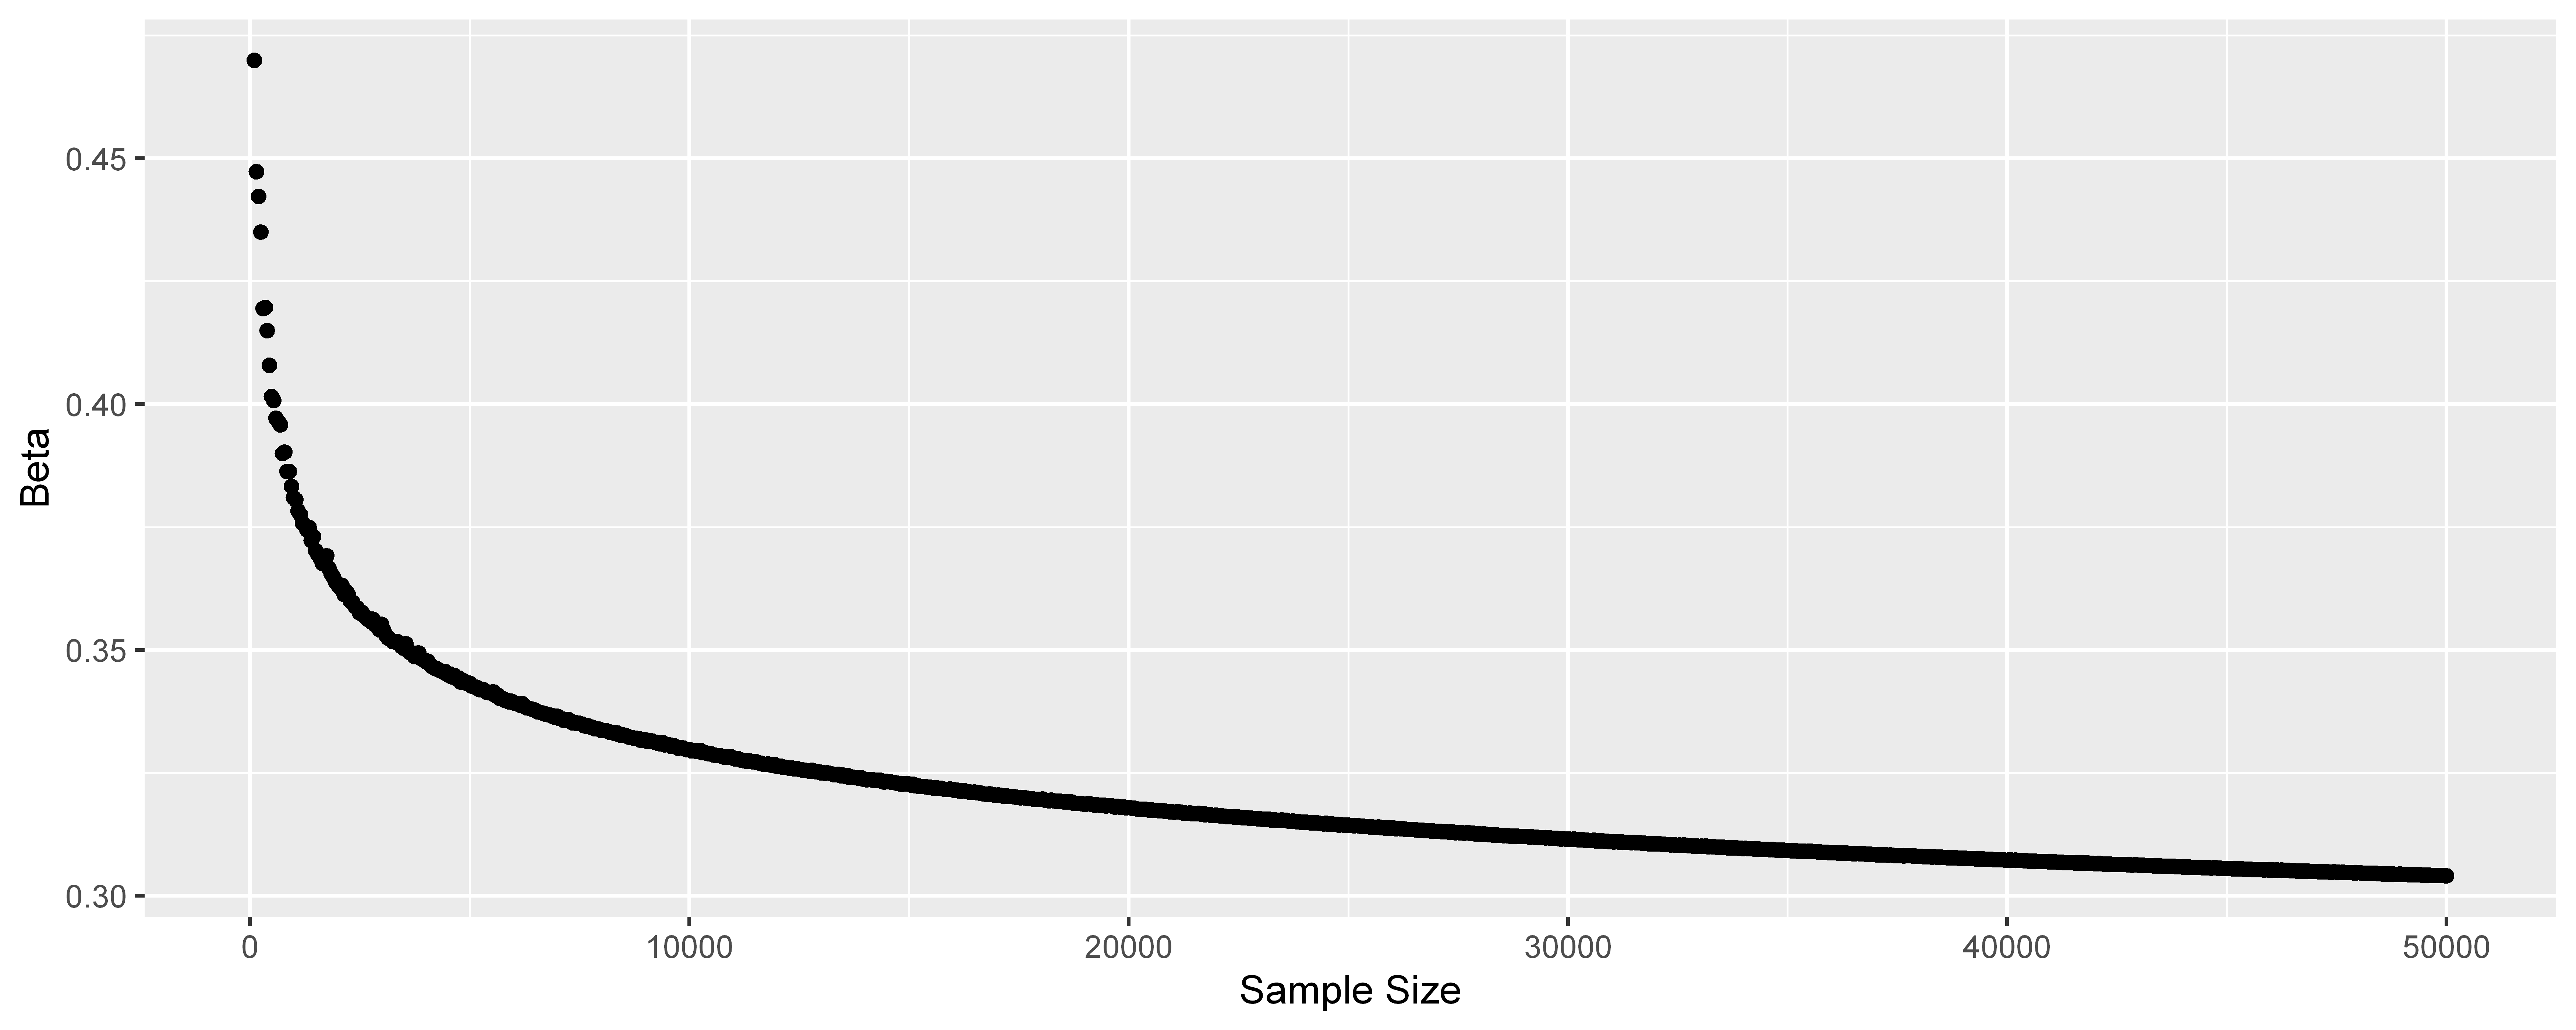

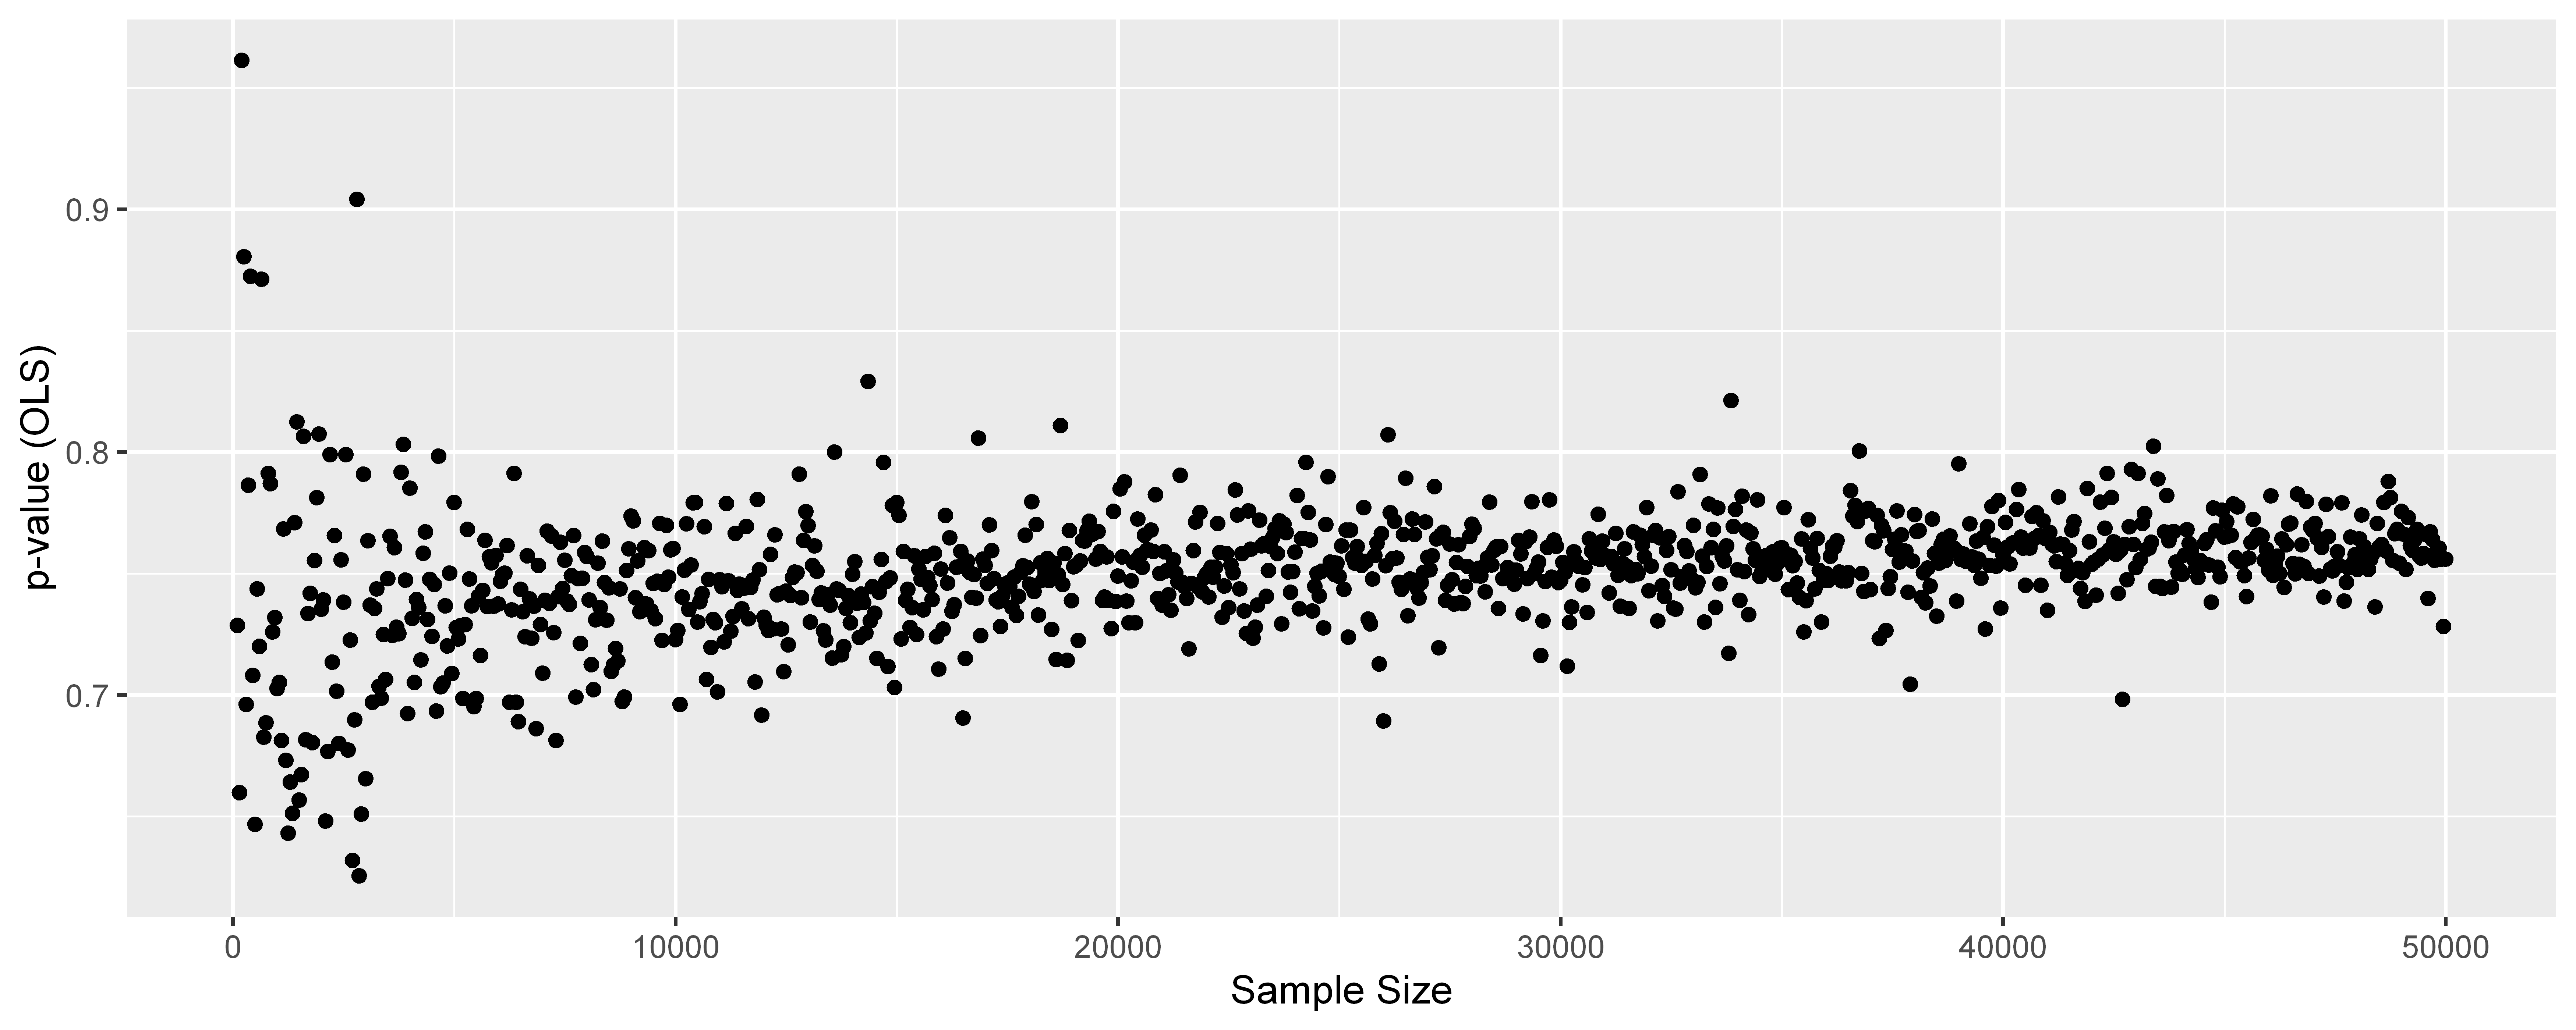

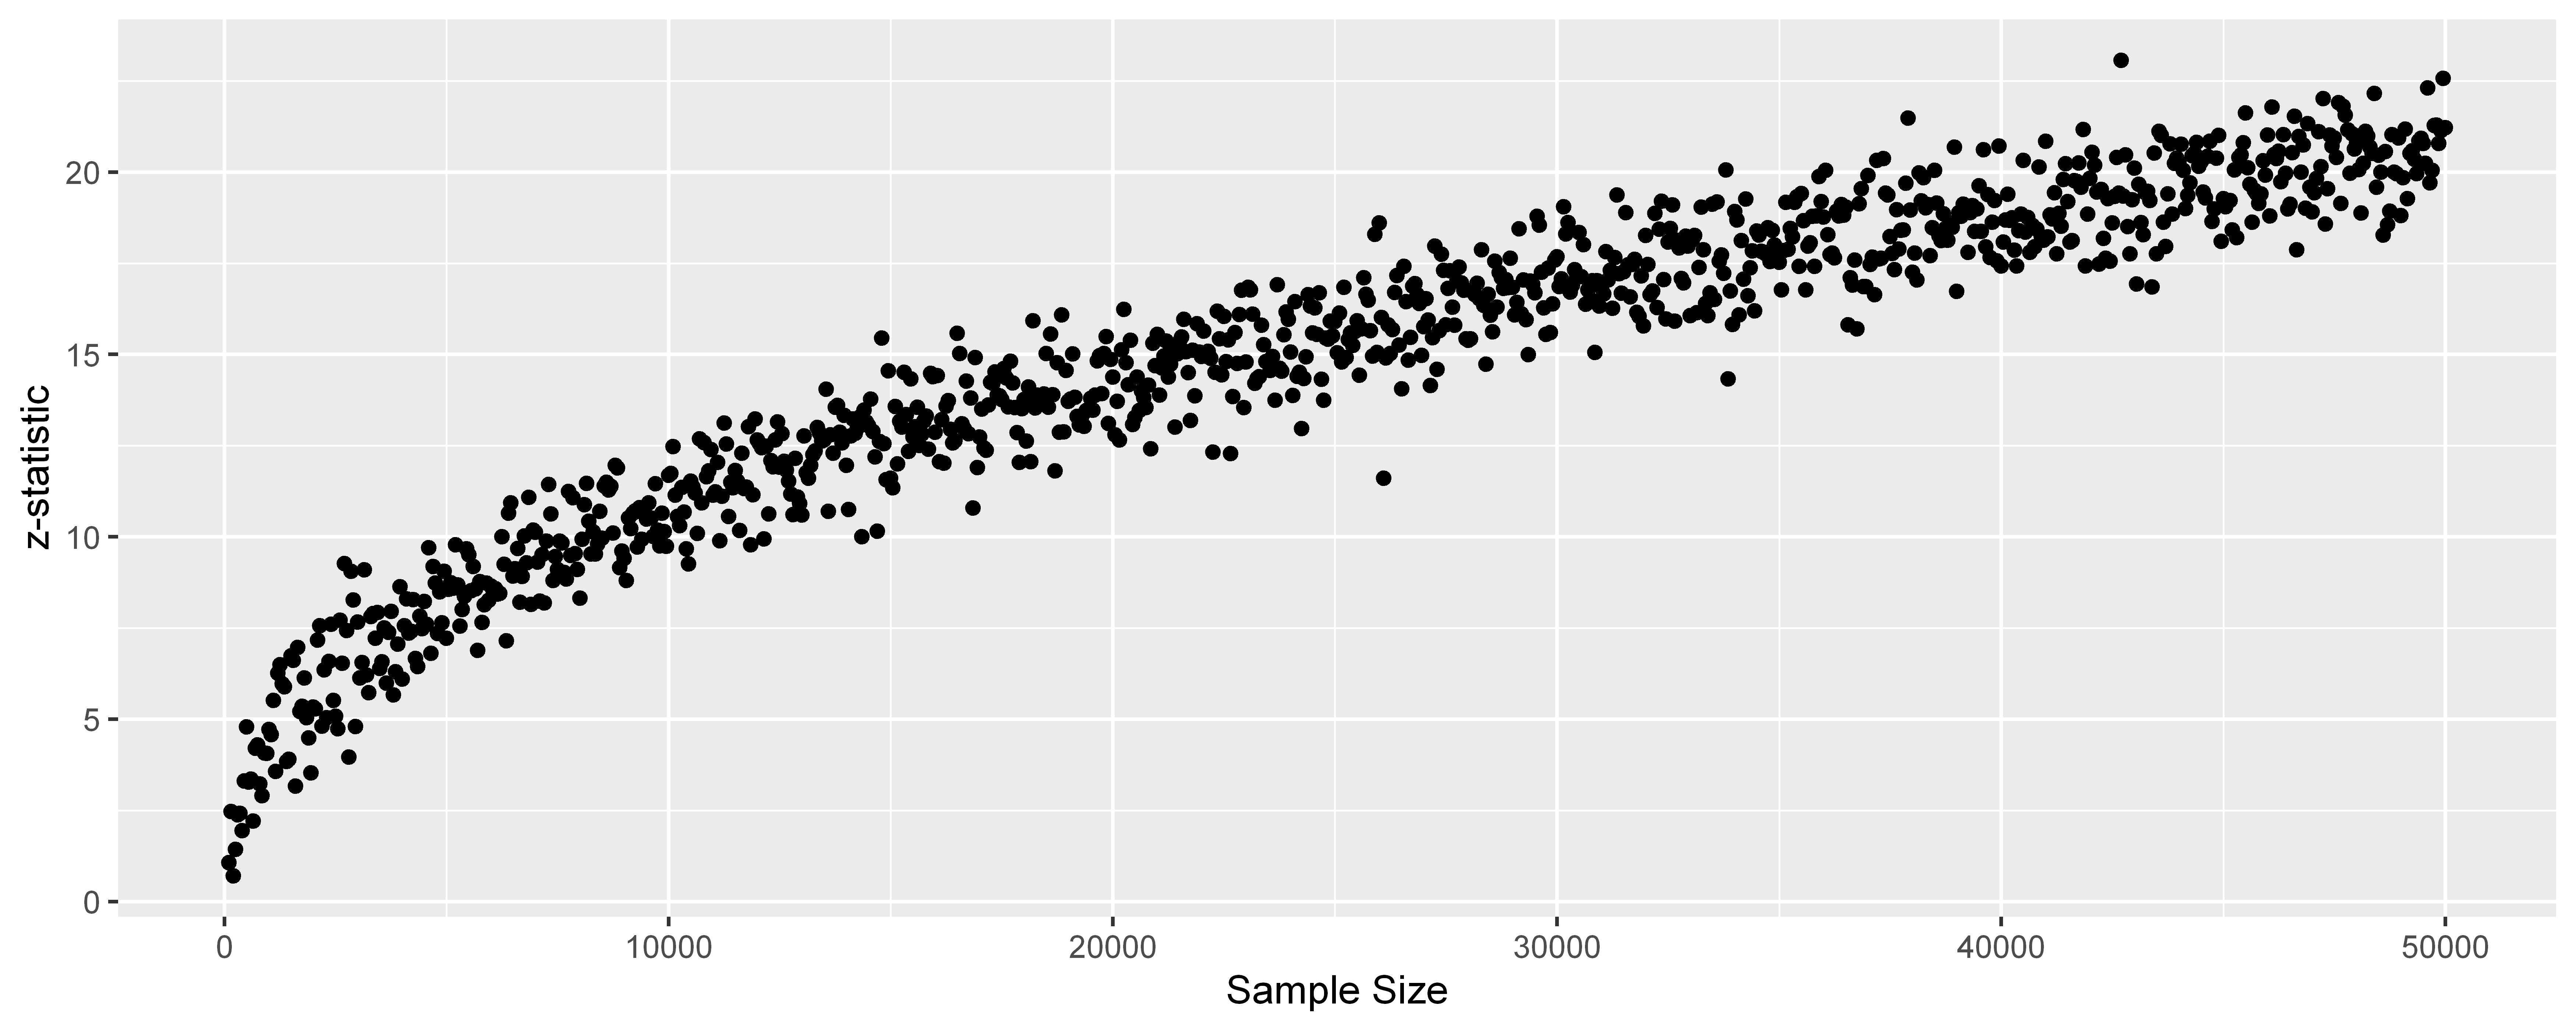

In [2]:
options(warn = -1)
set.seed(123)

df <- data.frame()
sample.size <- seq(100, 50000, by = 50) # create a sequence of sample size

for (n in sample.size) {
    x <- rnorm(n, mean = 0, sd = 1) # create the covariate/confounding variable X 
    alpha.true <- log(n) # treatment effect
    beta.m <- sqrt(n) # effect of X on Y
    r <- cbind(c(log(n), 0), c(0, log(n))) # covariance matrix of error terms (xi and nu)
    e <- mvrnorm(n = n, mu = c(0,0), Sigma = r, empirical = TRUE) 
    xi <- e[, 1] # error term (xi) in equation (5)
    nu <- e[, 2] # error term (nu) in equation (6)
    d <- beta.m * x + nu # create the policy/treatment variable (D)
    rho <- cor(x, d) # correlation of X and D
    c.n <- sd(xi) / (sd(x) * sqrt(1 - rho ^ 2) * log(n)) # create the constant c_n to generate the true parameter beta_g
    l.n <- log(n) # following Belloni et al. (2014)
    beta.g <- sqrt(l.n / n) * c.n
    y <- alpha.true * d + beta.g * x + xi 
    sigma.n <- sd(xi) / sd(d) # asymptotic lower bounds on variance of the estimator alpha_hat (for the parameter alpha)
    df.sim <- data.frame(x = x, d = d, y = y) 
    ols <- lm(y ~ d + x, df.sim) %>% summary() %>% coefficients 
    p <- ols[3, 4] # extract p-value from the OLS model
    c <- lm(y ~ d, df.sim) %>% summary() %>% coefficients
    alpha.hat <- c[2, 1] # extract the estimate of alpha
    df <- rbind(df, data.frame(z = abs((alpha.hat - alpha.true) * sqrt(n) / sigma.n), beta.g = beta.g, 
                               rho = rho, p = p, s = n)) # z-statistic
}

ggplot(df, aes(x = s, y = beta.g)) + geom_point() + xlab("Sample Size") + ylab("Beta") # convergence of the parameter beta_g
ggplot(df, aes(x = s, y = p)) + geom_point() + xlab("Sample Size") + ylab("p-value (OLS)")
ggplot(df, aes(x = s, y = z)) + geom_point() + xlab("Sample Size") + ylab("z-statistic") # divergence of the estimator alpha_hat 

**Figure 2:** The distribution of estimator for treatment effect in post-single selection

[1] "The probability that the confounding variable X is excluded from the linear model:  0.601"

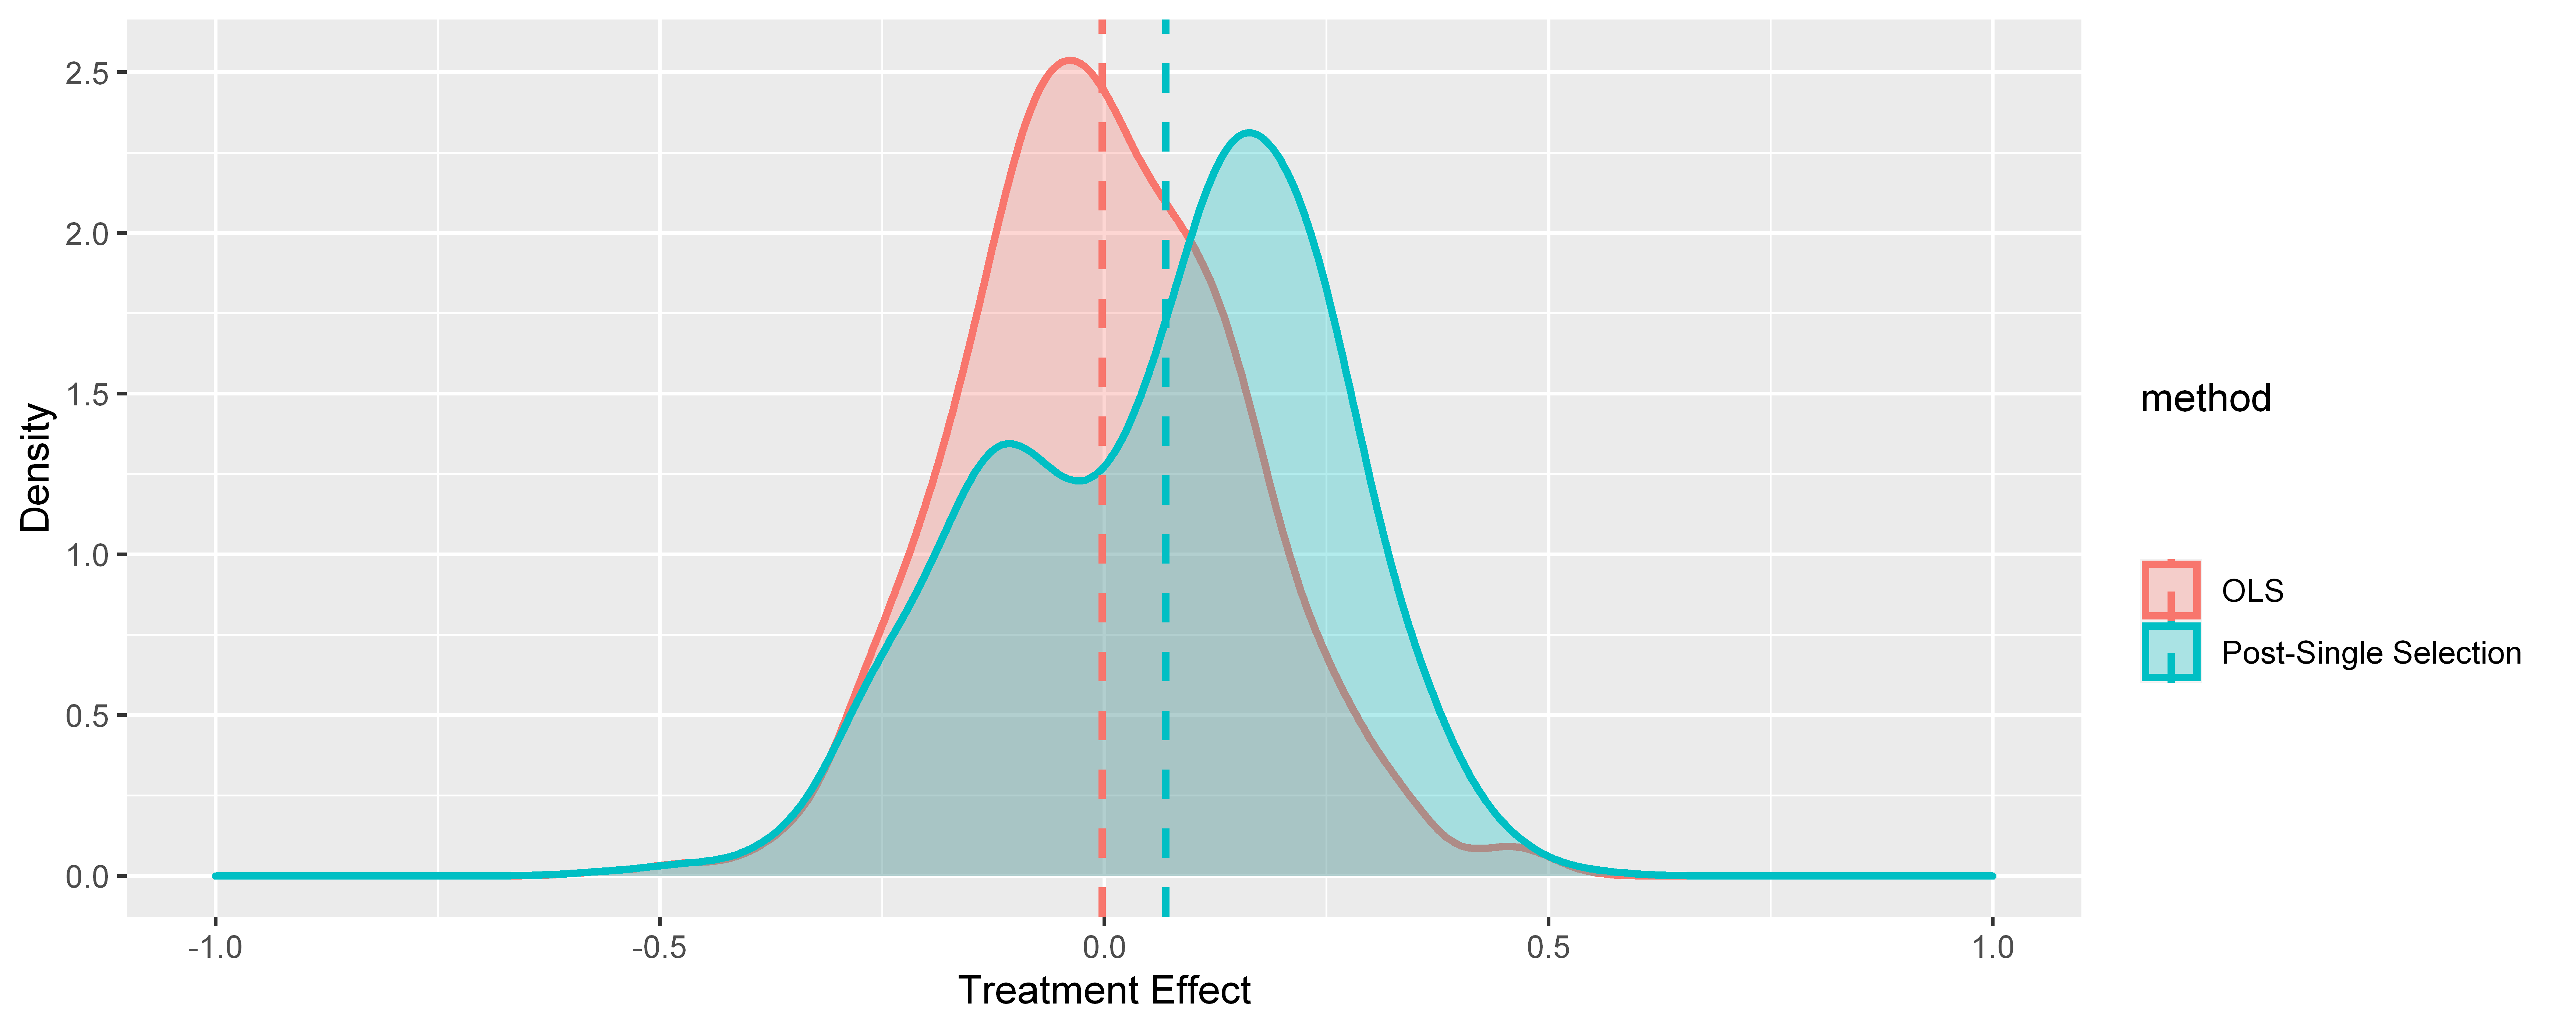

In [3]:
options(warn = -1)
set.seed(123)

df.true <- data.frame()
df.hat <- data.frame()
df <- data.frame()
num.sim <- 1000 # the number of simulations
alpha.true <- 0 # treatment effect
beta.true <- .25 
gamma <- .75
n <- 100 # sample size
num.reject <- 0 # calculate the number of times that t-test excludes the confounding variable X from the linear model

for (sim in 1:num.sim) {
    r <- cbind(c(1, gamma), c(gamma, 1))
    e <- mvrnorm(n = n, mu = c(0,0), Sigma = r, empirical = TRUE)
    x <- e[, 1]
    d <- e[, 2]
    epsilon <- rnorm(n, mean = 0, sd = 1)
    y <- alpha.true * d + beta.true * x + epsilon 
    df.sim <- data.frame(x = x, d = d, y = y)   
    true.model <- lm(y ~ d + x, df.sim) %>% summary() %>% coefficients
    alpha.hat.1 <- true.model[2, 1]
    if (true.model[3, 4] >= .05) { # use t-test for post-single selection
        num.reject <- num.reject + 1 # remove the confounding variable X if p-value is greater than or equal to 0.05
        post.single <- lm(y ~ d, df.sim) %>% summary() %>% coefficients
        alpha.hat.2 <- post.single[2, 1]
    } else {
        alpha.hat.2 <- alpha.hat.1
    }
    
    df.true <- rbind(df.true, data.frame(alpha.hat = alpha.hat.1, method = "OLS"))
    df.hat <- rbind(df.hat, data.frame(alpha.hat = alpha.hat.2, method = "Post-Single Selection"))
}

df.combine <- rbind(df.true, df.hat)
df.mean <- df.combine %>% group_by(method) %>% summarise_at(vars(alpha.hat), list(mean = mean))

ggplot() + 
geom_density(data = df.combine, aes(x = alpha.hat, color = method, fill = method), alpha = .3, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-1, 1) +
geom_vline(data = df.mean, aes(xintercept = df.mean$mean, color = df.mean$method), linetype='dashed', size = 1)

paste("The probability that the confounding variable X is excluded from the linear model: ", num.reject / num.sim)

**Figure 3:** The distribution of estimator for treatment effect in post-double selection

[1] "The probability that the confounding variable X is excluded from the linear model:  0"

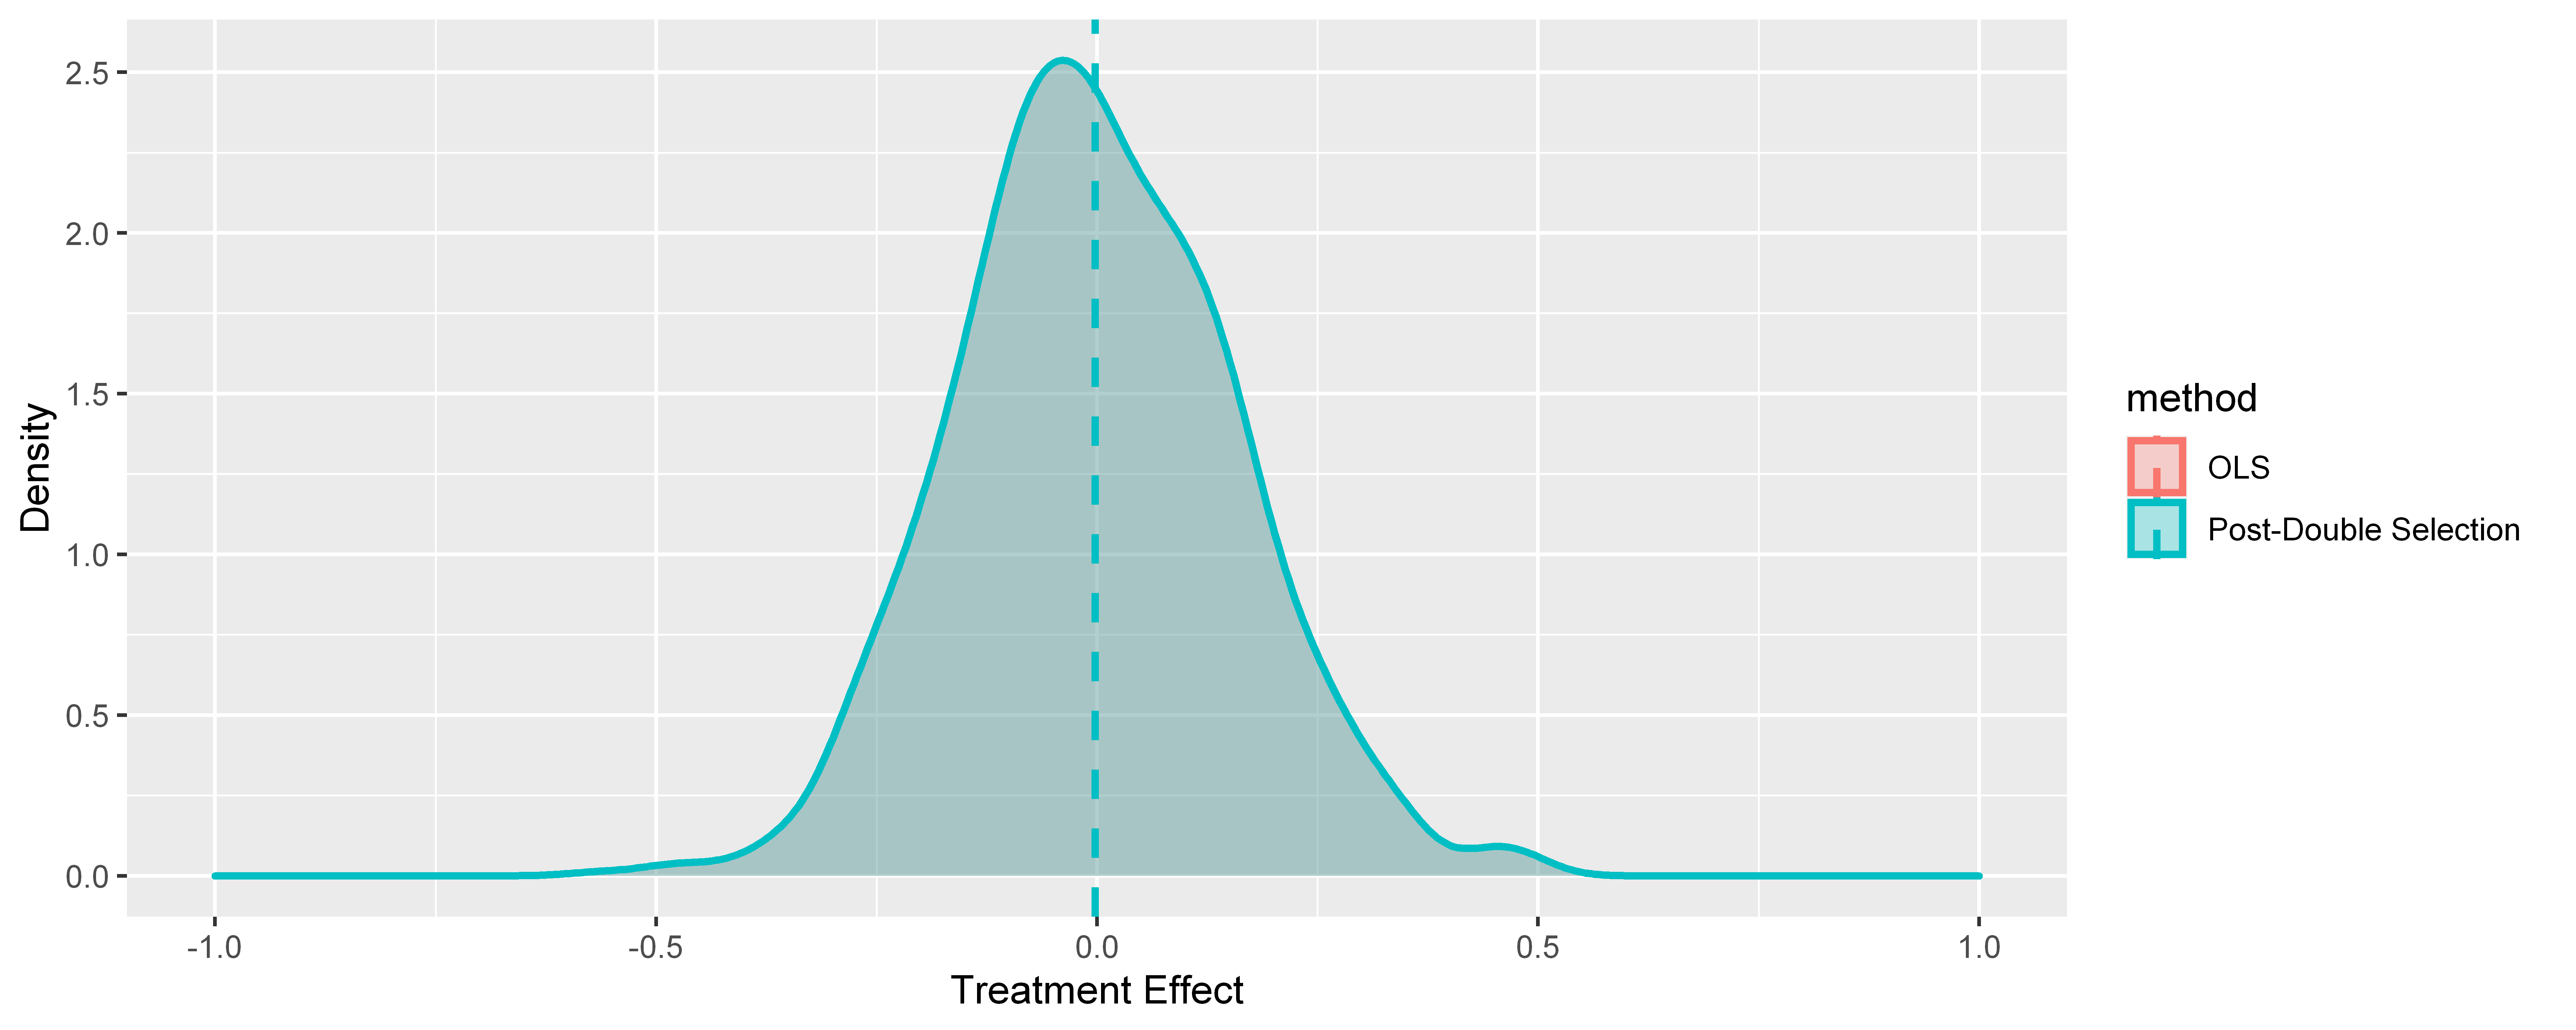

In [4]:
options(warn = -1)
set.seed(123)

df.true <- data.frame()
df.hat <- data.frame()
df <- data.frame()
num.sim <- 1000 # the number of simulations
alpha.true <- 0 # average treatment effect (ATE)
beta.true <- .25
gamma <- .75
n <- 100 # sample size
num.reject <- 0 # calculate the number of times that t-test excludes the confounding variable X from the linear model

for (sim in 1:num.sim) {
    r <- cbind(c(1, gamma), c(gamma, 1))
    e <- mvrnorm(n=n, mu=c(0,0), Sigma=r, empirical=TRUE)
    x <- e[, 1]
    d <- e[, 2]
    epsilon <- rnorm(n, mean = 0, sd = 1)
    y <- alpha.true * d + beta.true * x + epsilon 
    df.sim <- data.frame(x = x, d = d, y = y)   
    true.model <- lm(y ~ d + x, df.sim) %>% summary() %>% coefficients
    alpha.hat.1 <- true.model[2, 1]
    model.s1 <- lm(y ~ x, df.sim) %>% summary() %>% coefficients
    model.s2 <- lm(d ~ x, df.sim) %>% summary() %>% coefficients
    
    if (model.s1[2, 4] >= .05 & model.s2[2, 4] >= .05) { # use t-test for post-double selection
        num.reject <- num.reject + 1
        post.single <- lm(y ~ d, df.sim) %>% summary() %>% coefficients
        alpha.hat.2 <- post.single[2, 1]
    } else {
        alpha.hat.2 <- alpha.hat.1
    }
    
    df.true <- rbind(df.true, data.frame(alpha.hat = alpha.hat.1, method = "OLS"))
    df.hat <- rbind(df.hat, data.frame(alpha.hat = alpha.hat.2, method = "Post-Double Selection"))
}

df.combine <- rbind(df.true, df.hat)
df.mean <- df.combine %>% group_by(method) %>% summarise_at(vars(alpha.hat), list(mean = mean))

ggplot() + 
geom_density(data = df.combine, aes(x = alpha.hat, color = method, fill = method), alpha = .3, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-1, 1) + 
geom_vline(data = df.mean, aes(xintercept = df.mean$mean, color = df.mean$method), linetype='dashed', size = 1)

paste("The probability that the confounding variable X is excluded from the linear model: ", num.reject / num.sim)

**4.1 Data Generating Process**

In [5]:
dgp <- function(N, P, alpha) { # where N = sample size, P = # covariates/control variables, alpha = true coefficients
    df <- matrix(
    rnorm(n = N * P), 
    nrow = N, 
    ncol = P) %>% as.data.frame() %>% 
    mutate(
        D = V1 + V3 - V4 + V5 + V8 + rnorm(N)) %>% select(D, everything()) # based on equation ()  
    df$Y <- df %>% select(1:9) %>% as.matrix() %*% alpha + rnorm(N) # based on equation ()  
    df <- df %>% select(Y, D, everything())   
    return(df)
}

**4.2 Important Functions for Statistical Simulations**

**4.2.1 OLS**

In [6]:
# This function is created to extract OLS coefficients
ols <- function(N, P, alpha, N.sim) { # where N = sample size, P = # covariates/control variables, alpha = true coefficients
    te.ols <- data.frame()
    for (i in c(1:N.sim)) {
        df <- dgp(N, P, alpha)
        ols <- lm(Y ~ D + V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8, df) %>% # true model, based on equation ()
        tidy() %>% filter(term == "D")
        te.ols <- rbind(te.ols, ols)
        }
    return(te.ols)
}

In [7]:
# This function is created to extract sets of key control variables (confounding variables) for post-single/double selection methods
model.selection <- function(df, y, remove.vec) {
    Xmat <- df %>% select(-all_of(remove.vec)) %>% as.matrix()
    index <- grep(y , colnames(df)) # obtain column index (associated with dependent variables) in a data frame
    cv.lasso <- cv.glmnet(Xmat, df[[index]], alpha = 1)
    best.lambda <- cv.lasso$lambda.min # choose Lasso tuning parameter (lambda)
    lasso.reg <- glmnet(Xmat, df[[index]], alpha = 1, lambda = best.lambda)
    lasso.coefficients <- coef(lasso.reg) %>% as.matrix() %>% 
    as.data.frame() %>% 
    mutate(coef.names = row.names(.)) %>% 
    rename(est = s0) %>% 
    filter(est != 0) # select key variables associated with non-zero coefficients
    key.var <- lasso.coefficients$coef.names[-1]
    return(key.var)
}

**4.2.2 Post-Single Lasso**

In [8]:
# This function is created to obtain estimates of treatment effect using post-single selection method
post.single.lasso <- function(N, P, alpha, N.sim){
    te.pss <- data.frame()
    for (i in c(1:N.sim)) {
        df <- dgp(N, P, alpha)
        key.vars <- model.selection(df = df, y = "Y", remove.vec = c(1))
        pss <- df %>% select(Y, D, all_of(key.vars)) %>% 
        lm(Y ~ ., data = .) %>% summary() %>% coefficients %>% .[2, ] %>% t() %>% as.data.frame()
        te.pss <- rbind(te.pss, pss)
    }
    return(te.pss)
}

**4.2.3 Post-Double Lasso (Cross-validation)**

In [9]:
# This function is created to obtain estimates of treatment effect using post-double selection method
# using k-fold cross-validation to select optimal tuning parameter (lambda) 
post.double.lasso.cv <- function(N, P, alpha, N.sim){
    te.pds.cv <- data.frame()
    for (i in c(1:N.sim)) {
        df <- dgp(N, P, alpha)
        key.vars.y <- model.selection(df = df, y = "Y", remove.vec = c(1:2))
        key.vars.d <- model.selection(df = df, y = "D", remove.vec = c(1:2))
        key.vars <- append(key.vars.y, key.vars.d)
        key.vars <- as.vector(unique(key.vars, incomparables = FALSE))
        pds <- df %>% select(Y, D, all_of(key.vars)) %>% 
        lm(Y ~ ., data = .) %>% summary() %>% coefficients %>% .[2, ] %>% t() %>% as.data.frame()
        te.pds.cv <- rbind(te.pds.cv, pds)
    }
    return(te.pds.cv)
}

**4.2.4 Post-Double Lasso (Belloni, Chernozhukov, Hansen)**

In [10]:
# This function is created to obtain estimates of treatment effect using post-double selection method
# using the closed-form solution of optimal tuning parameter (lambda), developed by Belloni et al. (2014)
post.double.lasso.bch <- function(N, P, alpha, N.sim){
    te.pds.bch <- data.frame()
    for (i in c(1:N.sim)) {
        df <- dgp(N, P, alpha)
        pds <- rlassoEffect(x = df %>% select(-Y, -D) %>% as.matrix(),
                 y = df$Y, d = df$D, method = "double selection") %>% 
                 summary() %>% coefficients %>% as.data.frame()
        te.pds.bch <- rbind(te.pds.bch, pds)
    }
    return(te.pds.bch)
}

**Figure 4:** The directed acyclic graph for the simulation study

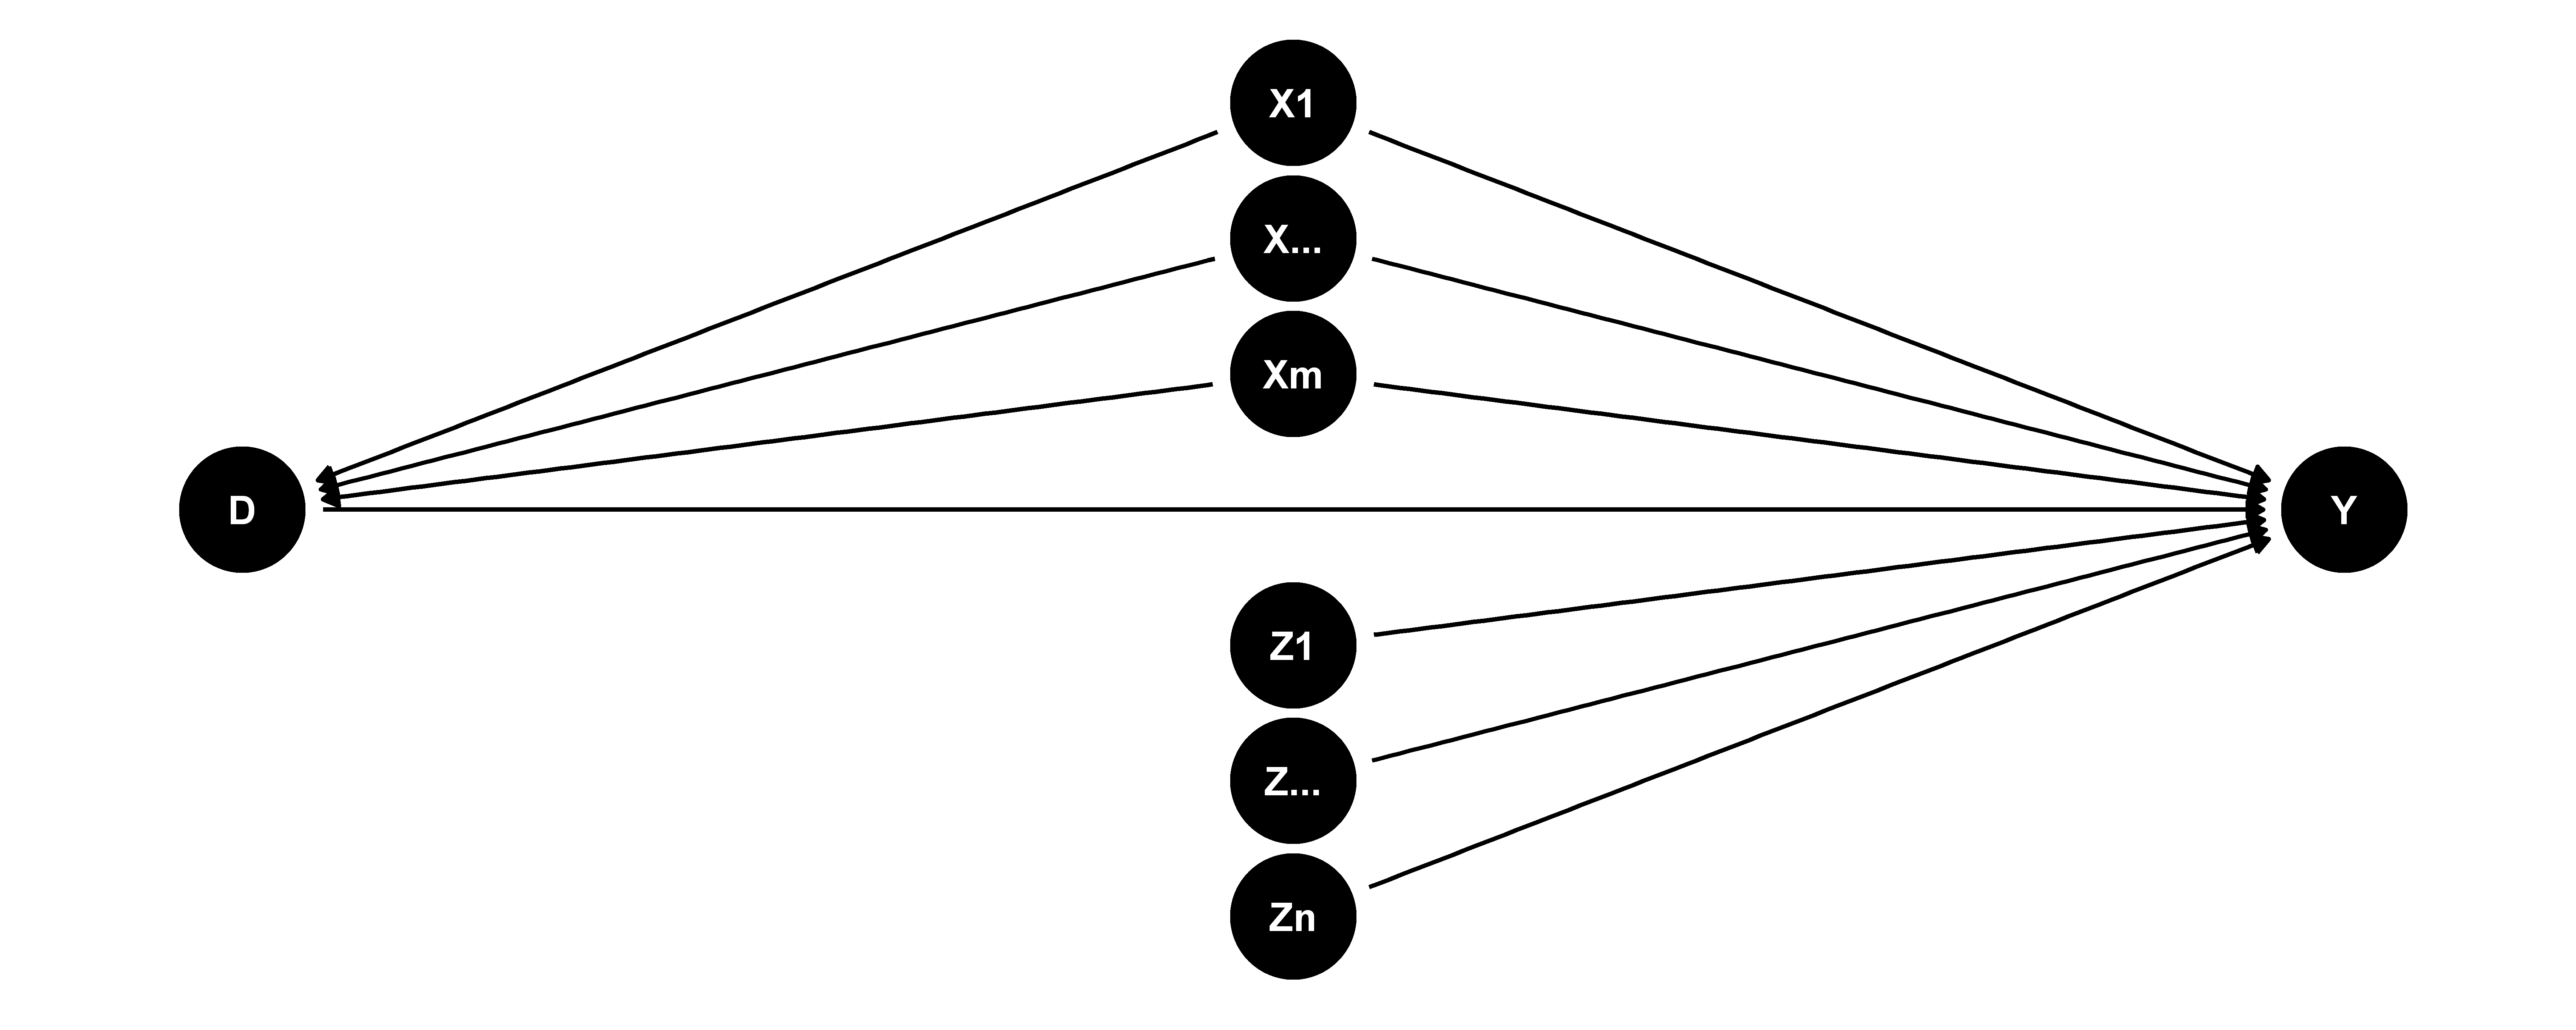

In [11]:
coords <- list(
    x = c(D = 1, Xm = 2, X... = 2, X1 = 2, Z1 = 2, Z... = 2, Zn = 2, Y = 3),
    y = c(D = 0, Xm = 1, X... = 2, X1 = 3, Z1 = -1, Z... = -2, Zn = -3, Y = 0)
    )

dagify(Y ~ D + X1 + X... + Xm + Z1 + Z... + Zn,
       D ~ X1 + X... + Xm, coords = coords) %>% ggdag() + theme_dag()

**4.3 Performance Comparison between Model Selection Methods**

In [12]:
# This function is created to obtain estimates of treatment effect by combining all model selection methods
method.comparison <- function(N, P, alpha, N.sim) {
    df.ols <- ols(N, P, alpha, N.sim) %>% select(2) %>% mutate(method = "OLS") %>% rename(te = estimate)
    df.pss <- post.single.lasso(N, P, alpha, N.sim) %>% select(1) %>% 
    mutate(method = "Post-Single Lasso") %>% rename(te = Estimate)
    df.pds.cv <- post.double.lasso.cv(N, P, alpha, N.sim) %>% select(1) %>% 
    mutate(method = "Post-Double Lasso (CV)") %>% rename(te = Estimate)
    df.pds.bch <- post.double.lasso.bch(N, P, alpha, N.sim) %>% select(1) %>% 
    mutate(method = "Post-Double Lasso (BCH)") %>% rename(te = Estimate.)
    te.all <- rbind(df.ols, df.pss, df.pds.cv, df.pds.bch) 
    return(te.all)
}

**4.3.1 The Effect of Abortion on Violent Crime**

**Figure 5:** The Effect of Abortion on Violent Crime

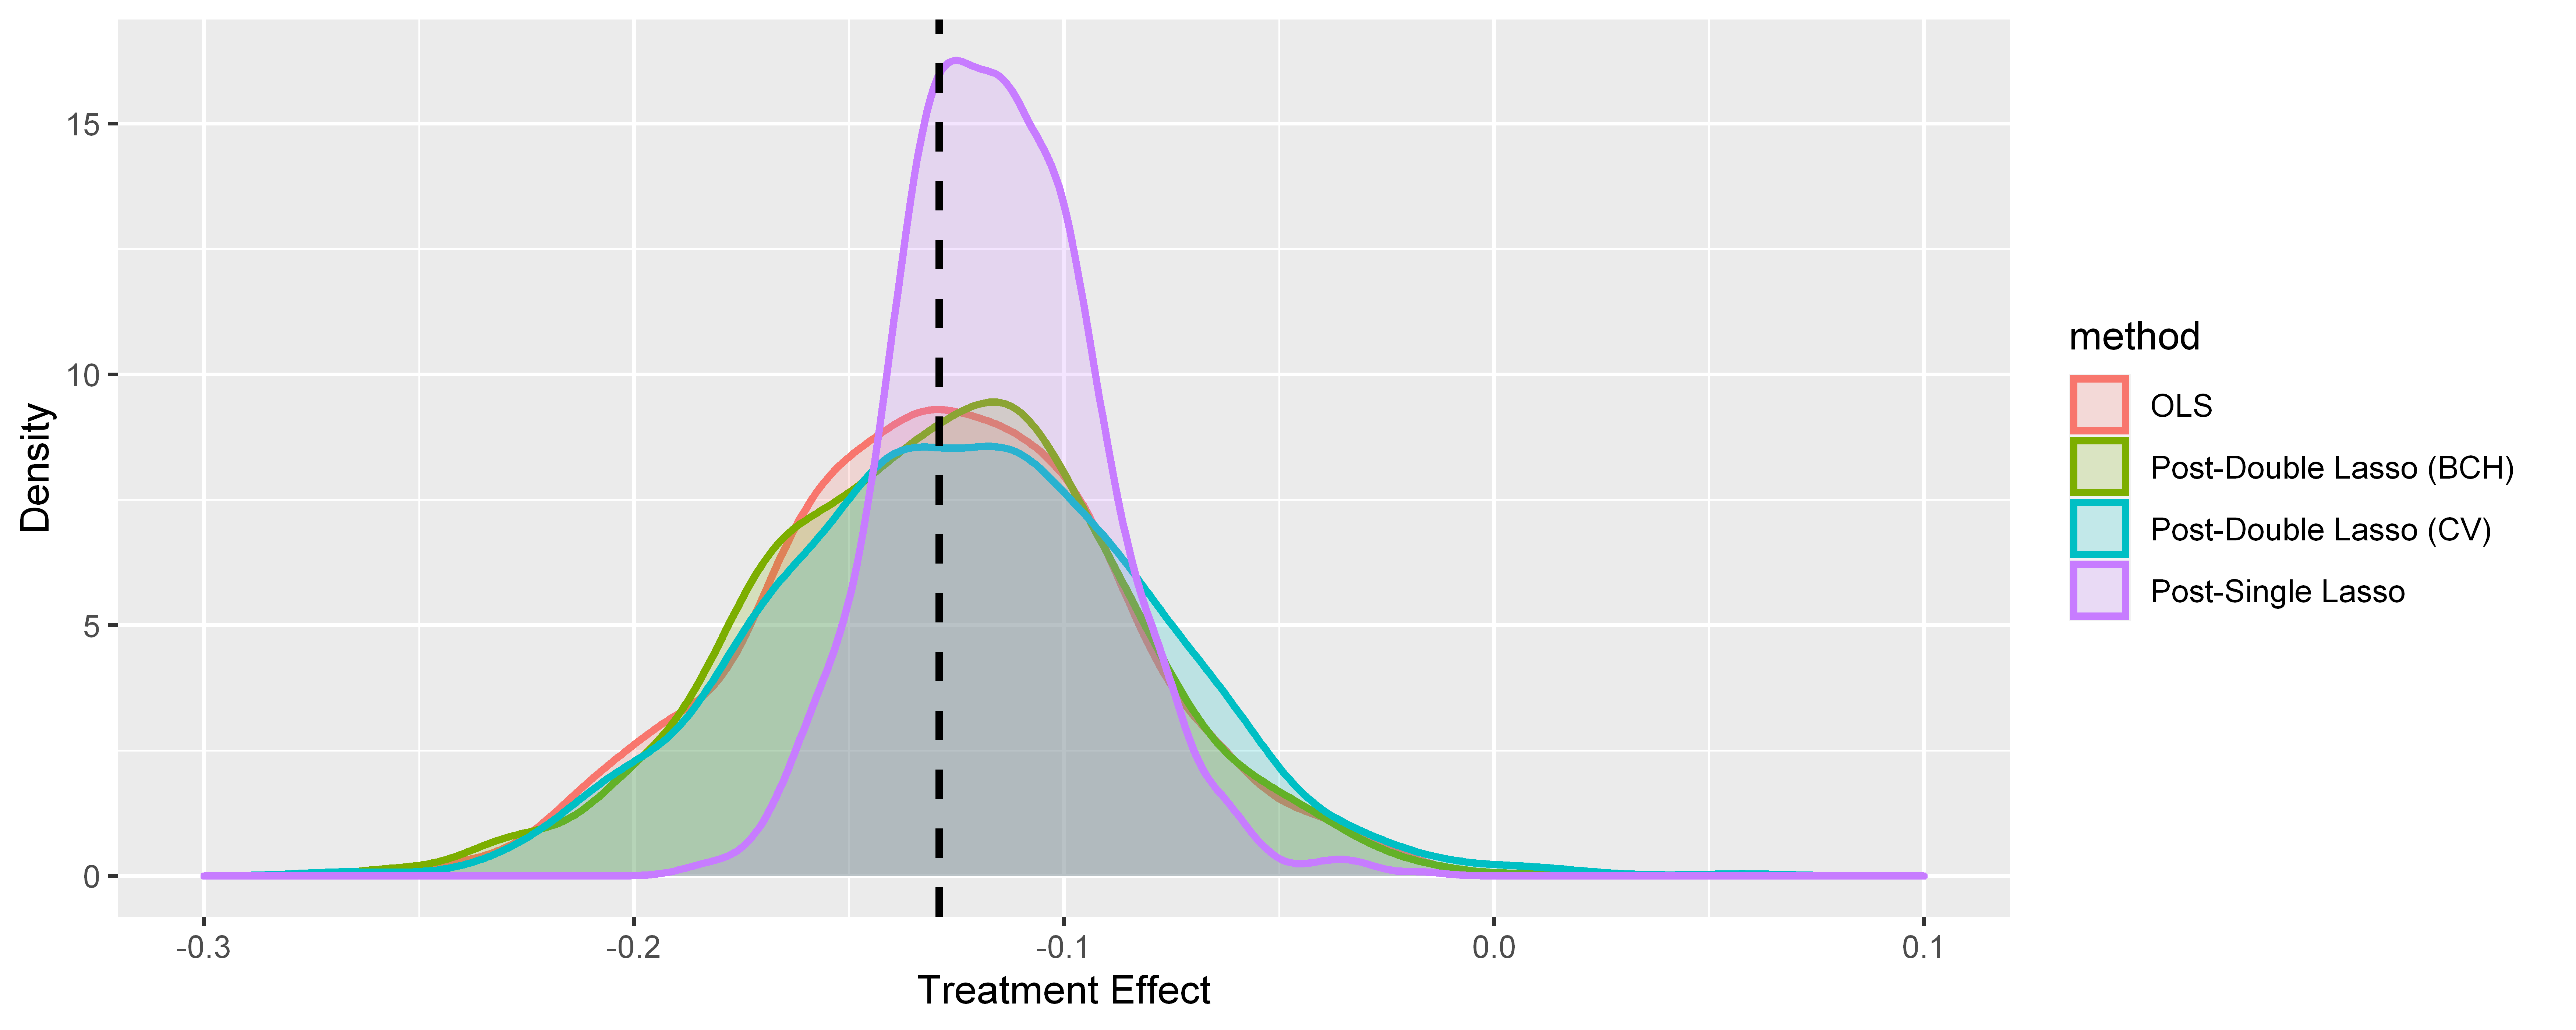

In [13]:
set.seed(123)

N <- 576
P <- 284
alpha <- c(-0.129, -0.027, -0.028, 0.069, 0.049, -0.001, 0.008, -0.004, 0.004) 
# coefficients are taken from Donohue III and Levitt (2001) Table IV, column (2)
N.sim <- 1000

df.te.vio <- method.comparison(N, P, alpha, N.sim)
# saveRDS(df.te.vio, file = "violentcrime.Rda")

ggplot(df.te.vio, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.129, linetype = 'dashed', size = 1)

**4.3.2 The Effect of Abortion on Property Crime**

**Figure 6:** The Effect of Abortion on Property Crime

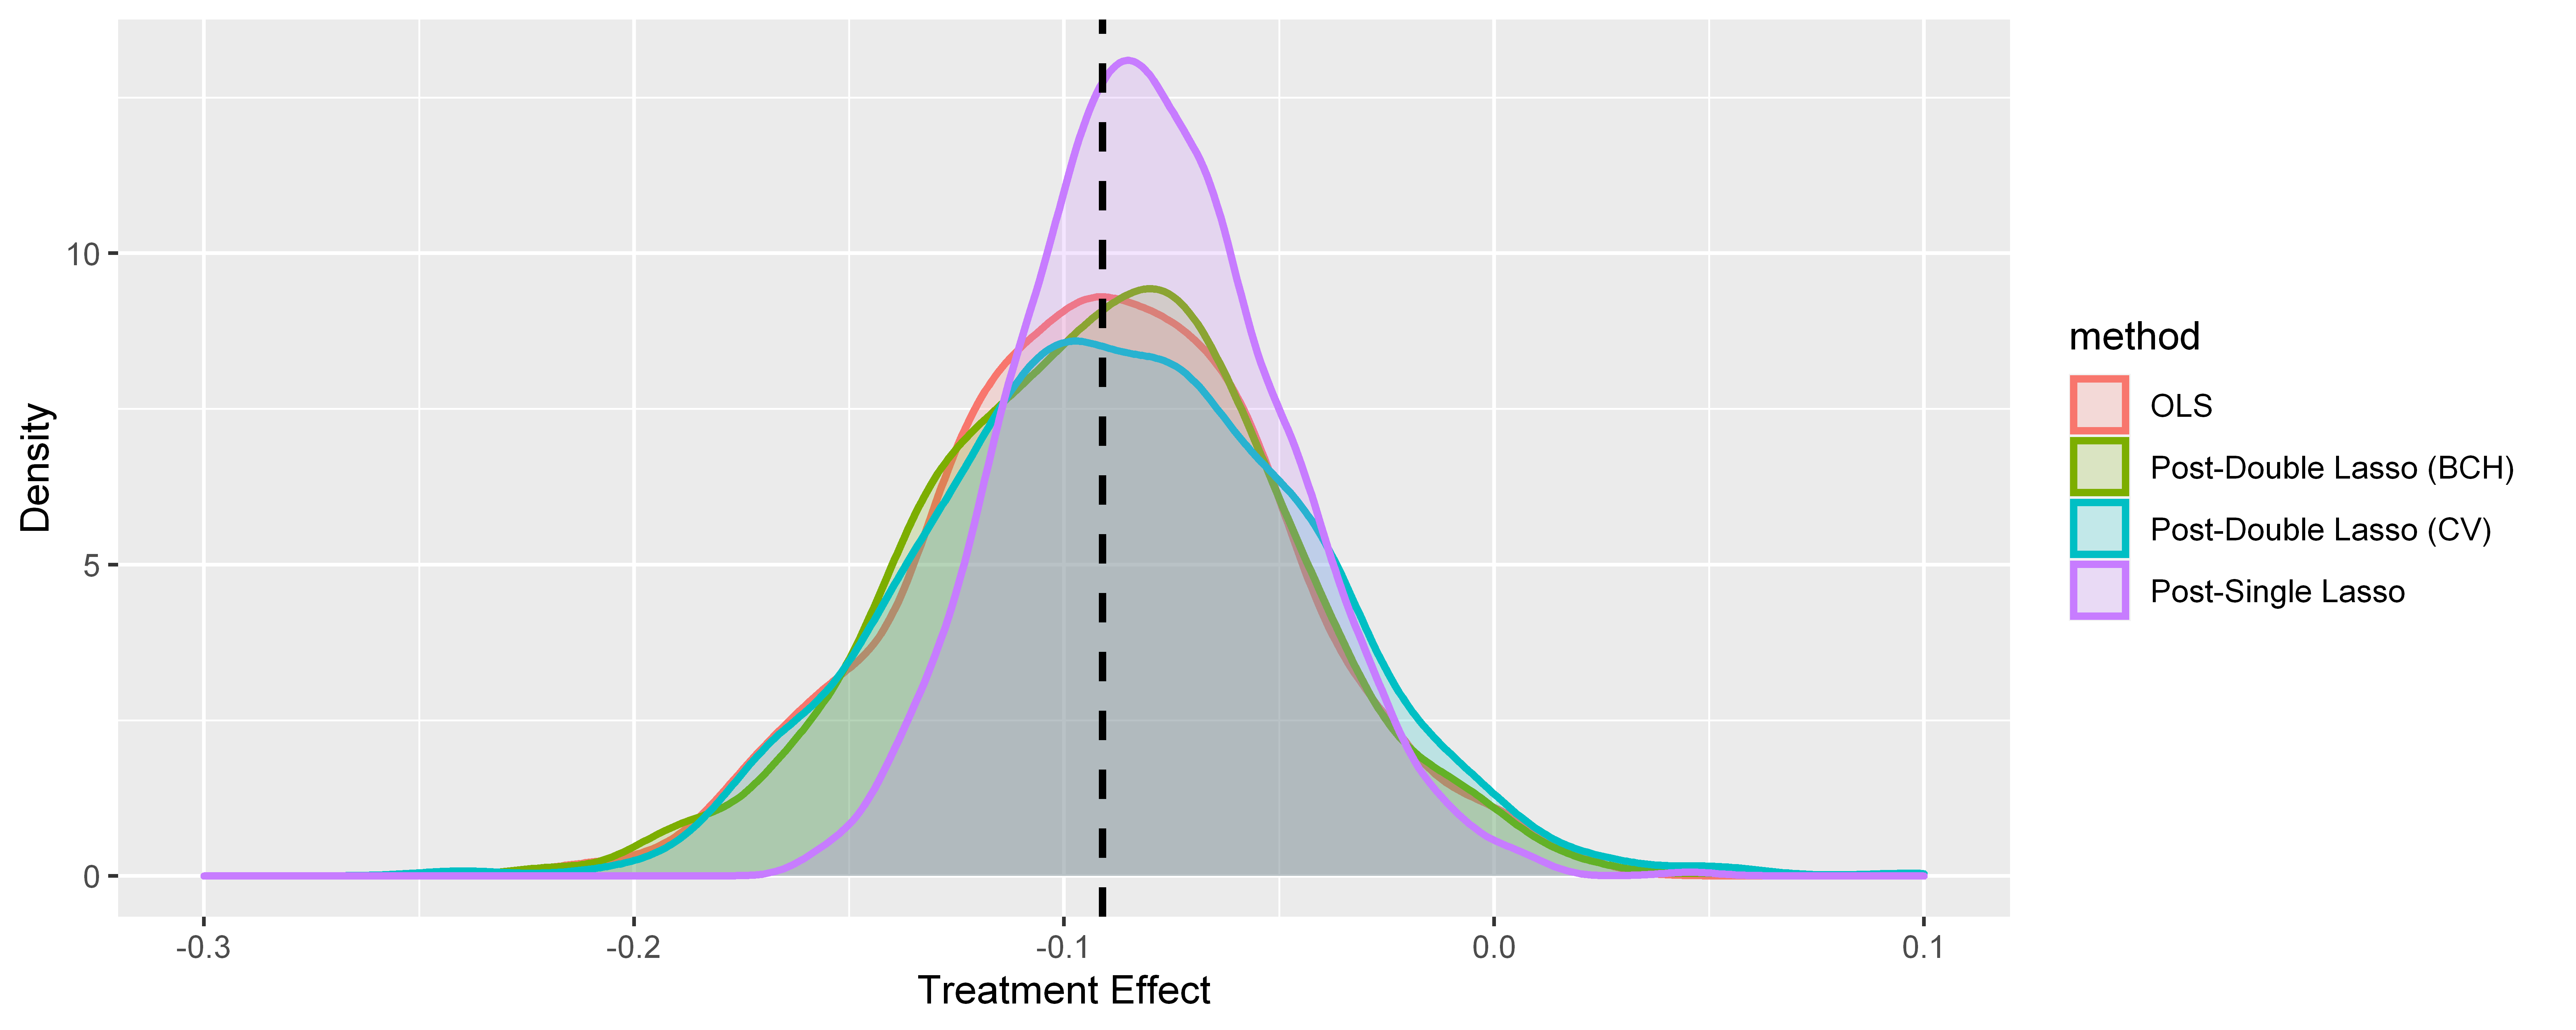

In [14]:
set.seed(123)

N <- 576
P <- 284
alpha <- c(-0.091, -0.159, -0.049, 1.310, 0.084, -0.001, 0.002, 0.039, 0.004) 
# coefficients are taken from Donohue III and Levitt (2001) Table IV, column (4)
N.sim <- 1000

df.te.prop <- method.comparison(N, P, alpha, N.sim)
# saveRDS(df.te.prop, file = "propertycrime.Rda")

ggplot(df.te.prop, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.091, linetype = 'dashed', size = 1)

**4.3.3 The Effect of Abortion on Murder**

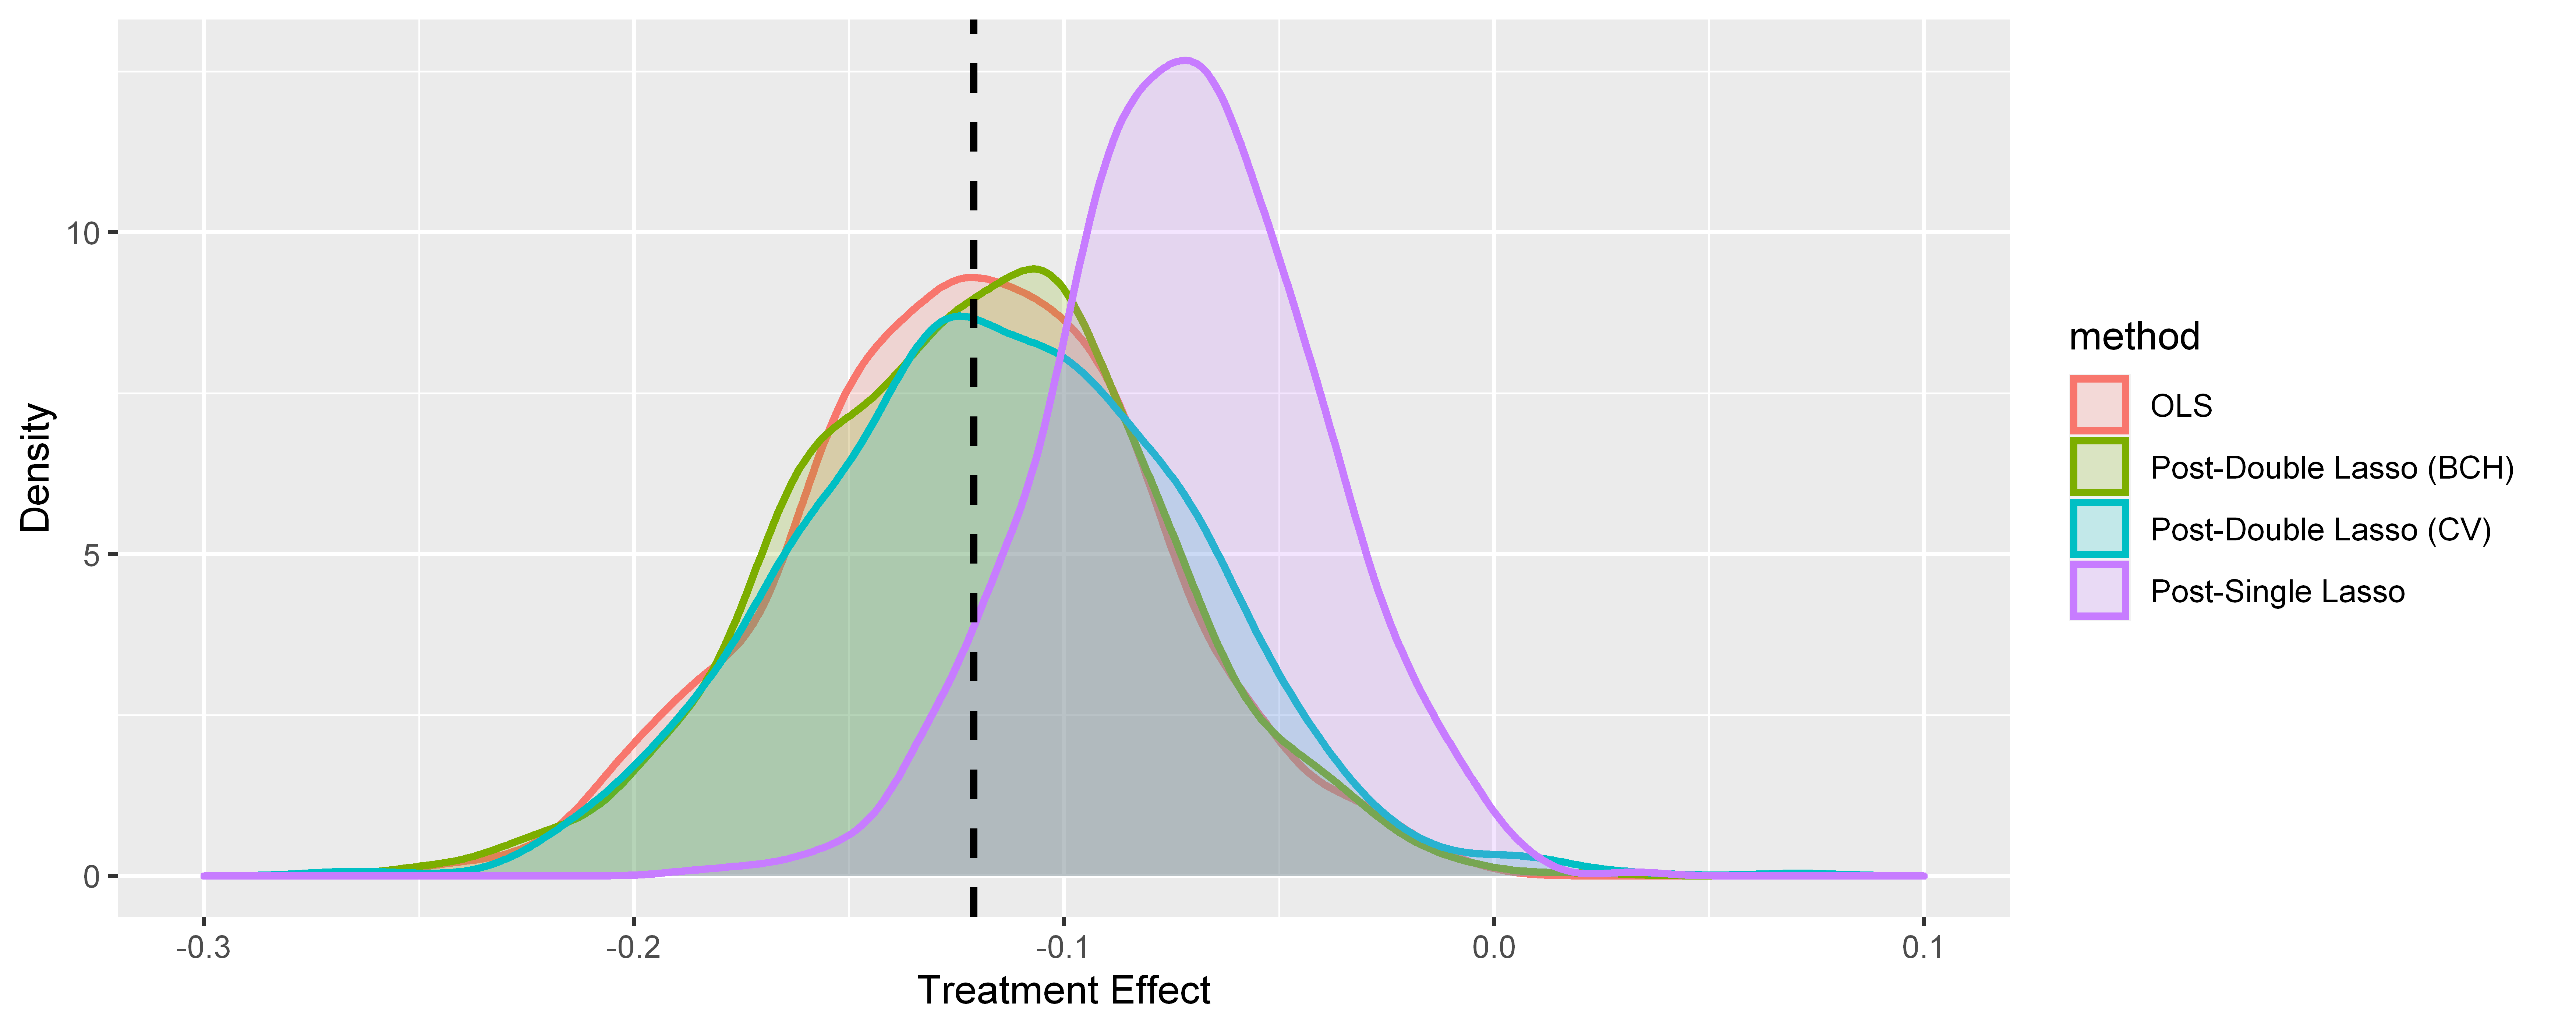

In [15]:
set.seed(123)

N <- 576
P <- 284
alpha <- c(-0.121, -0.231, -0.300, 0.968, -0.098, -0.005, -0.001, -0.015, 0.006)
# coefficients are taken from Donohue III and Levitt (2001) Table IV, column (6)
N.sim <- 1000

df.te.murd <- method.comparison(N, P, alpha, N.sim)
# saveRDS(df.te.murd, file = "murder.Rda")

ggplot(df.te.murd, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.121, linetype = 'dashed', size = 1)

**Note:** It takes a lot of time to run the code for sections **4.3.1, 4.3.2, and 4.3.3** (1.5 - 2 hours). I saved data frames containing estimates of treatment effects as R objects. You just need to load them and run the below code for data visualization (Figures 5, 6, and 7 in my report). 

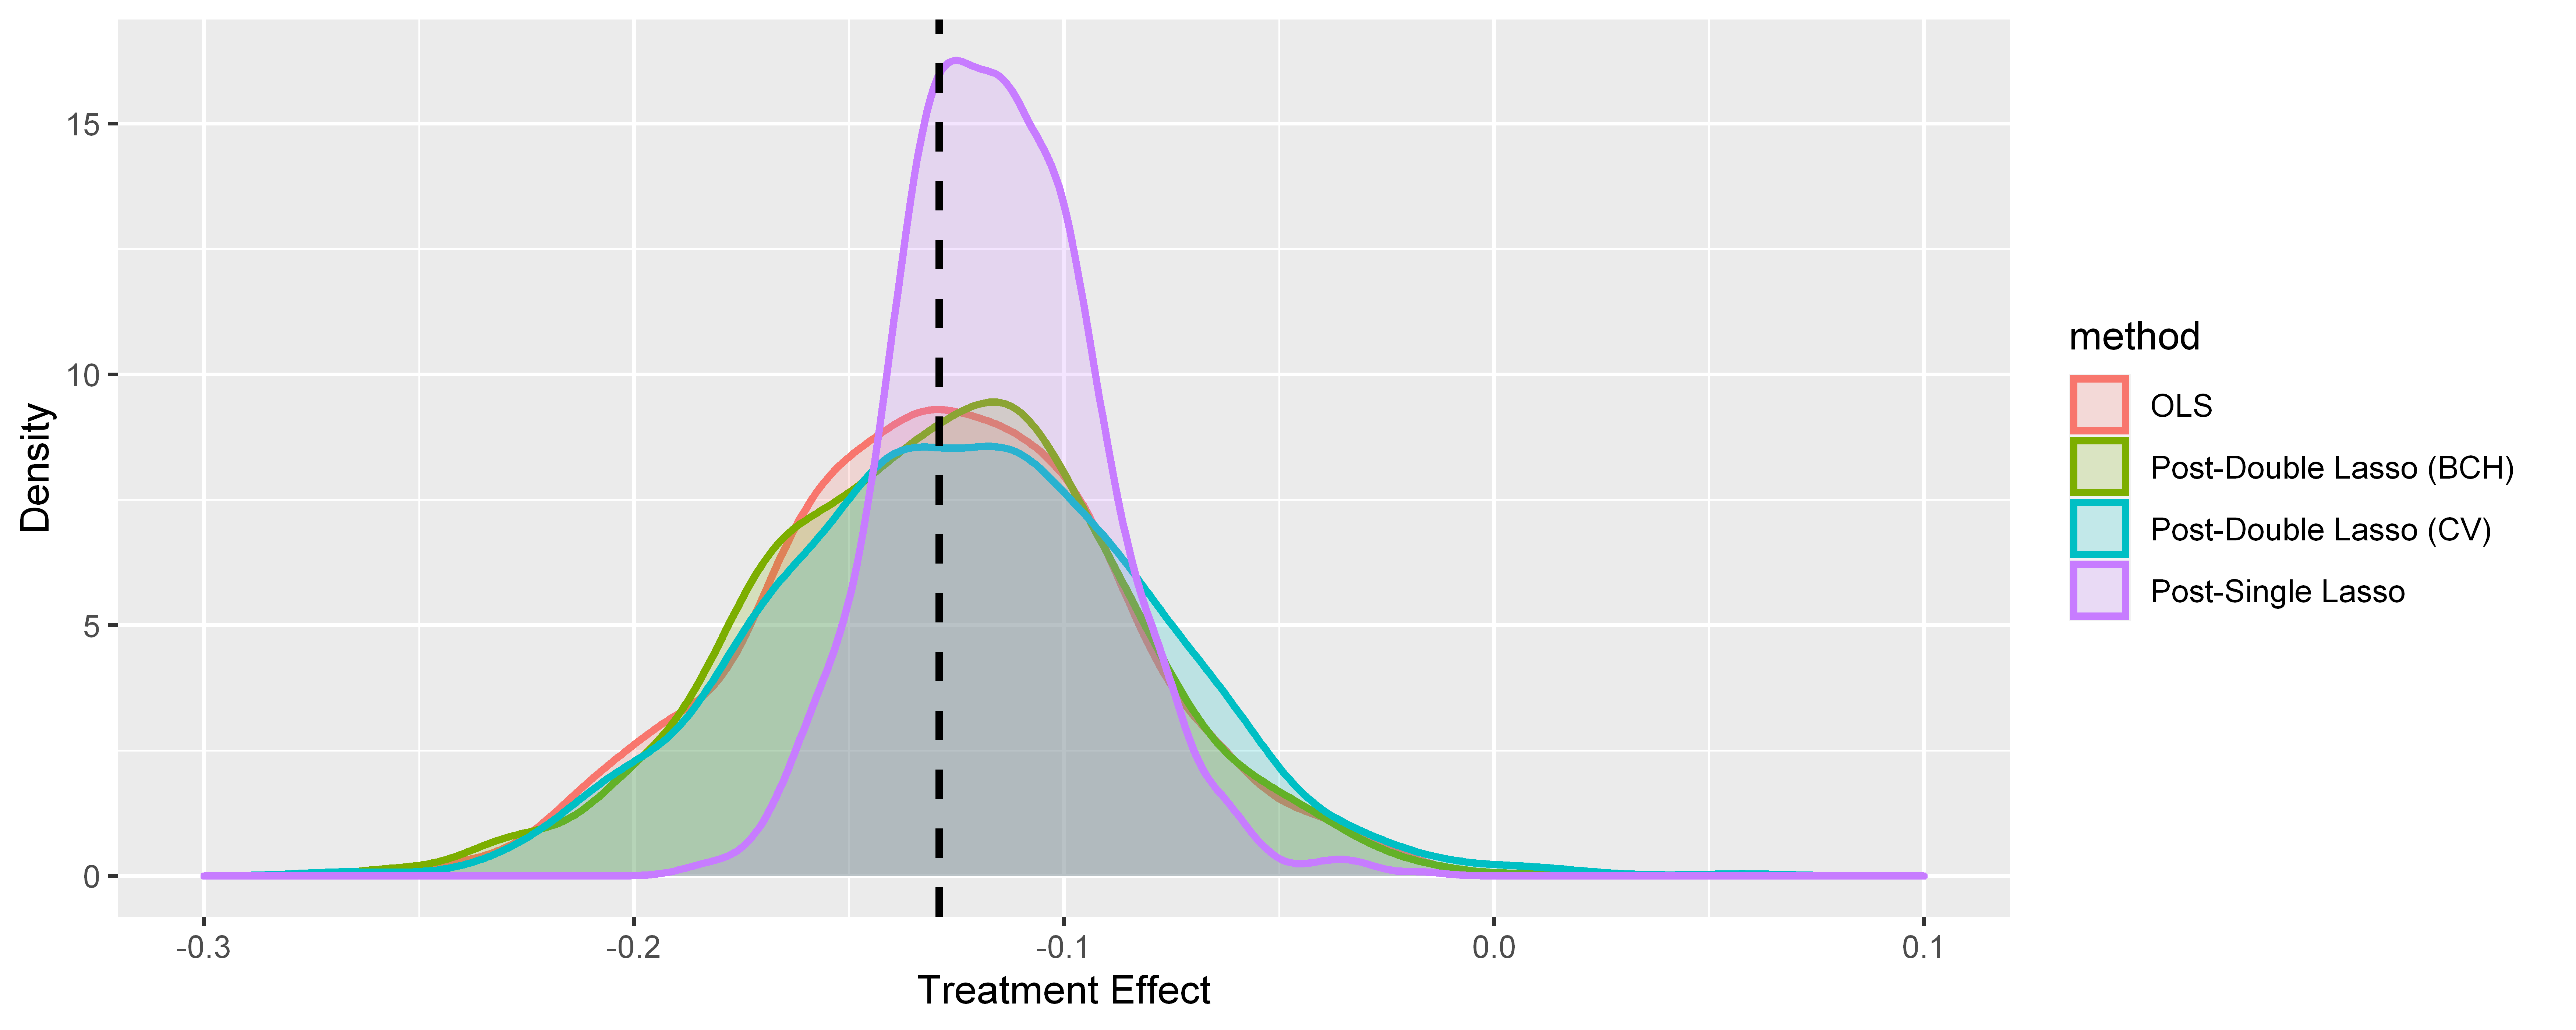

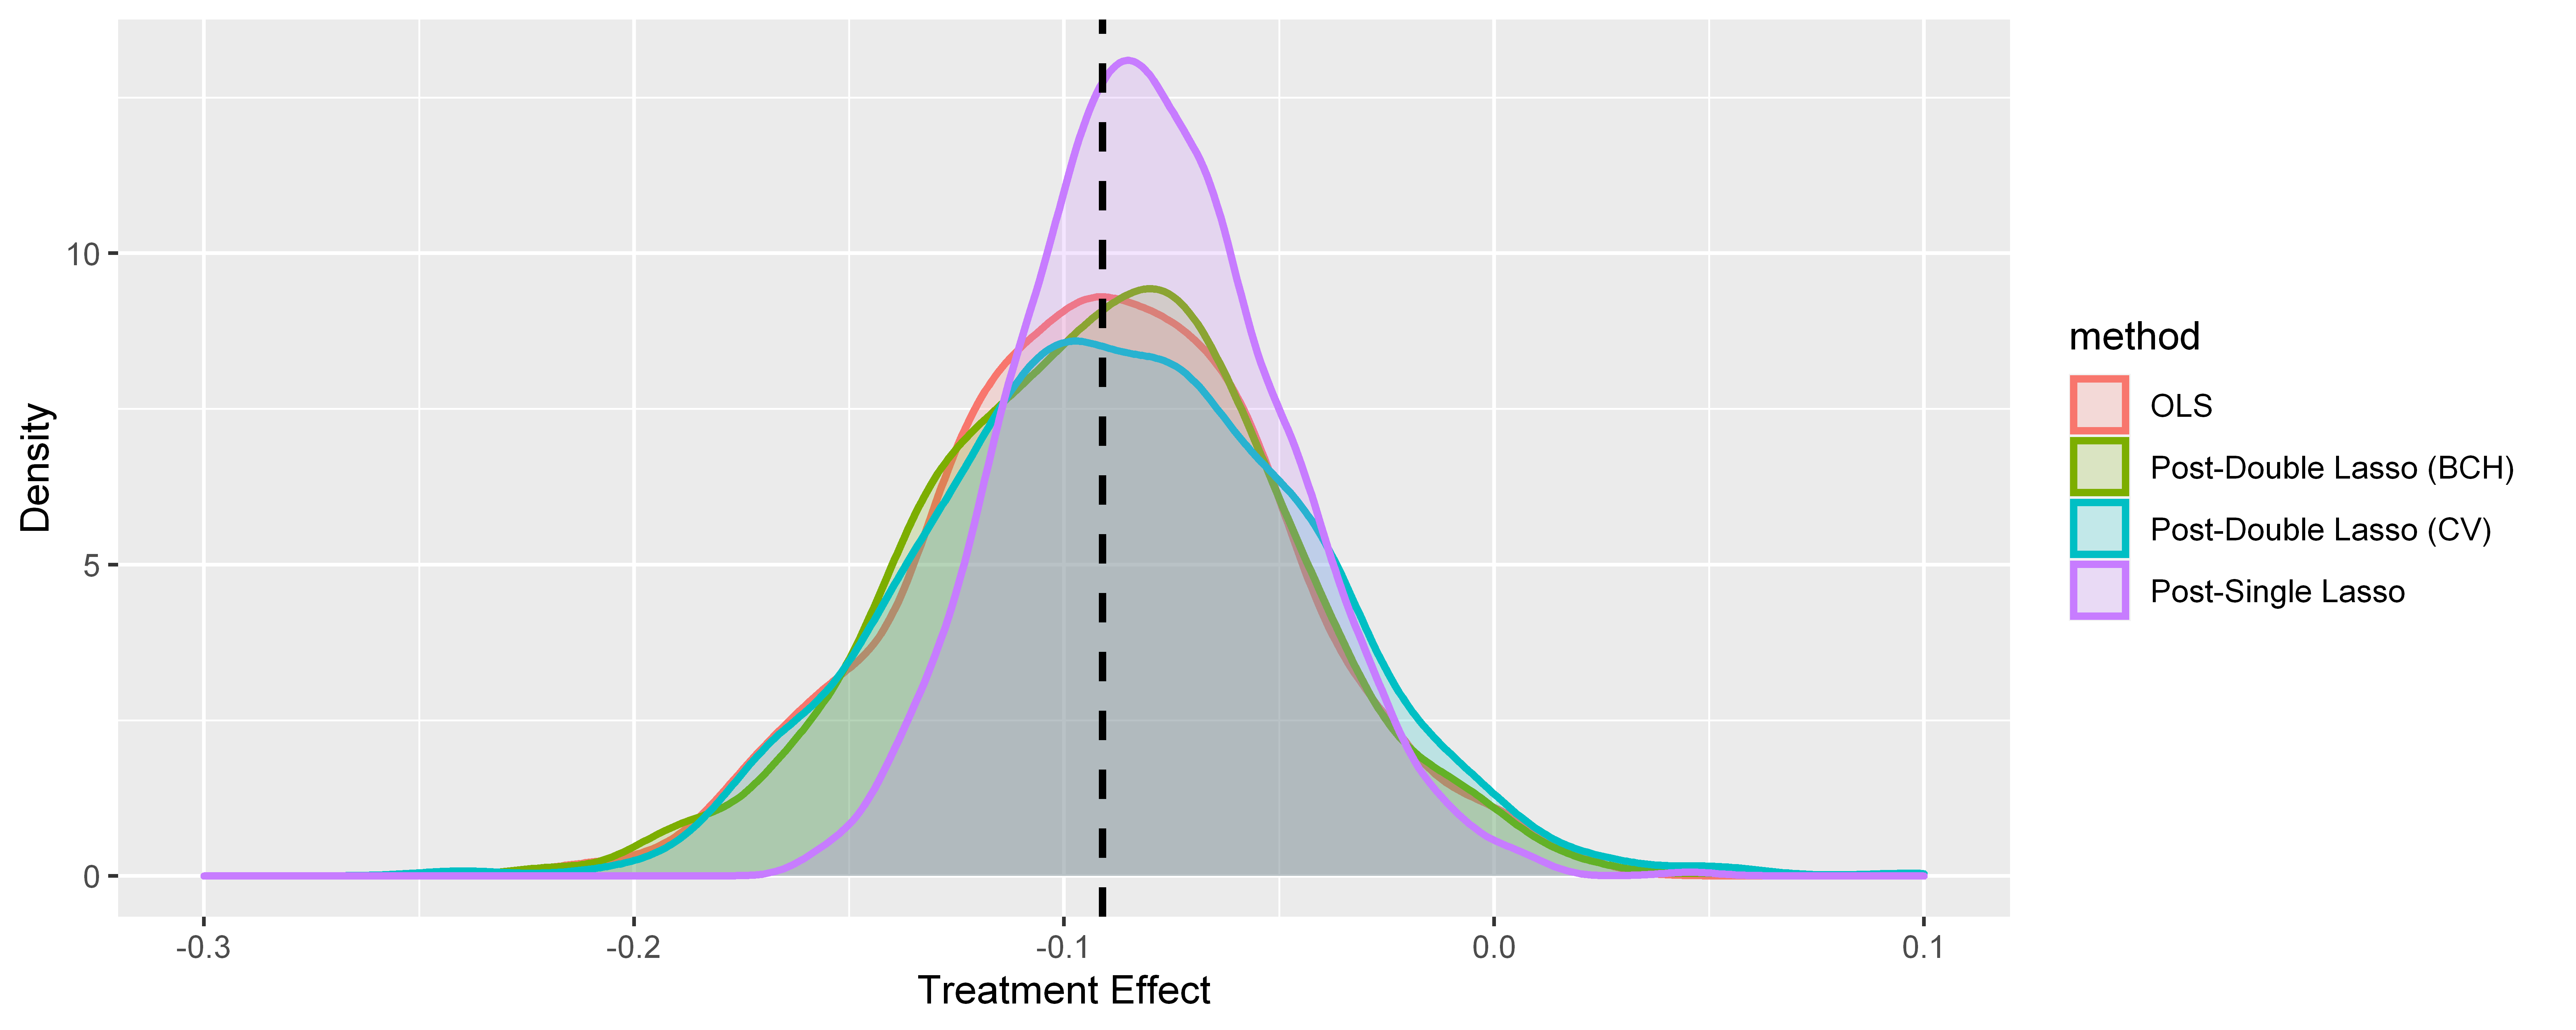

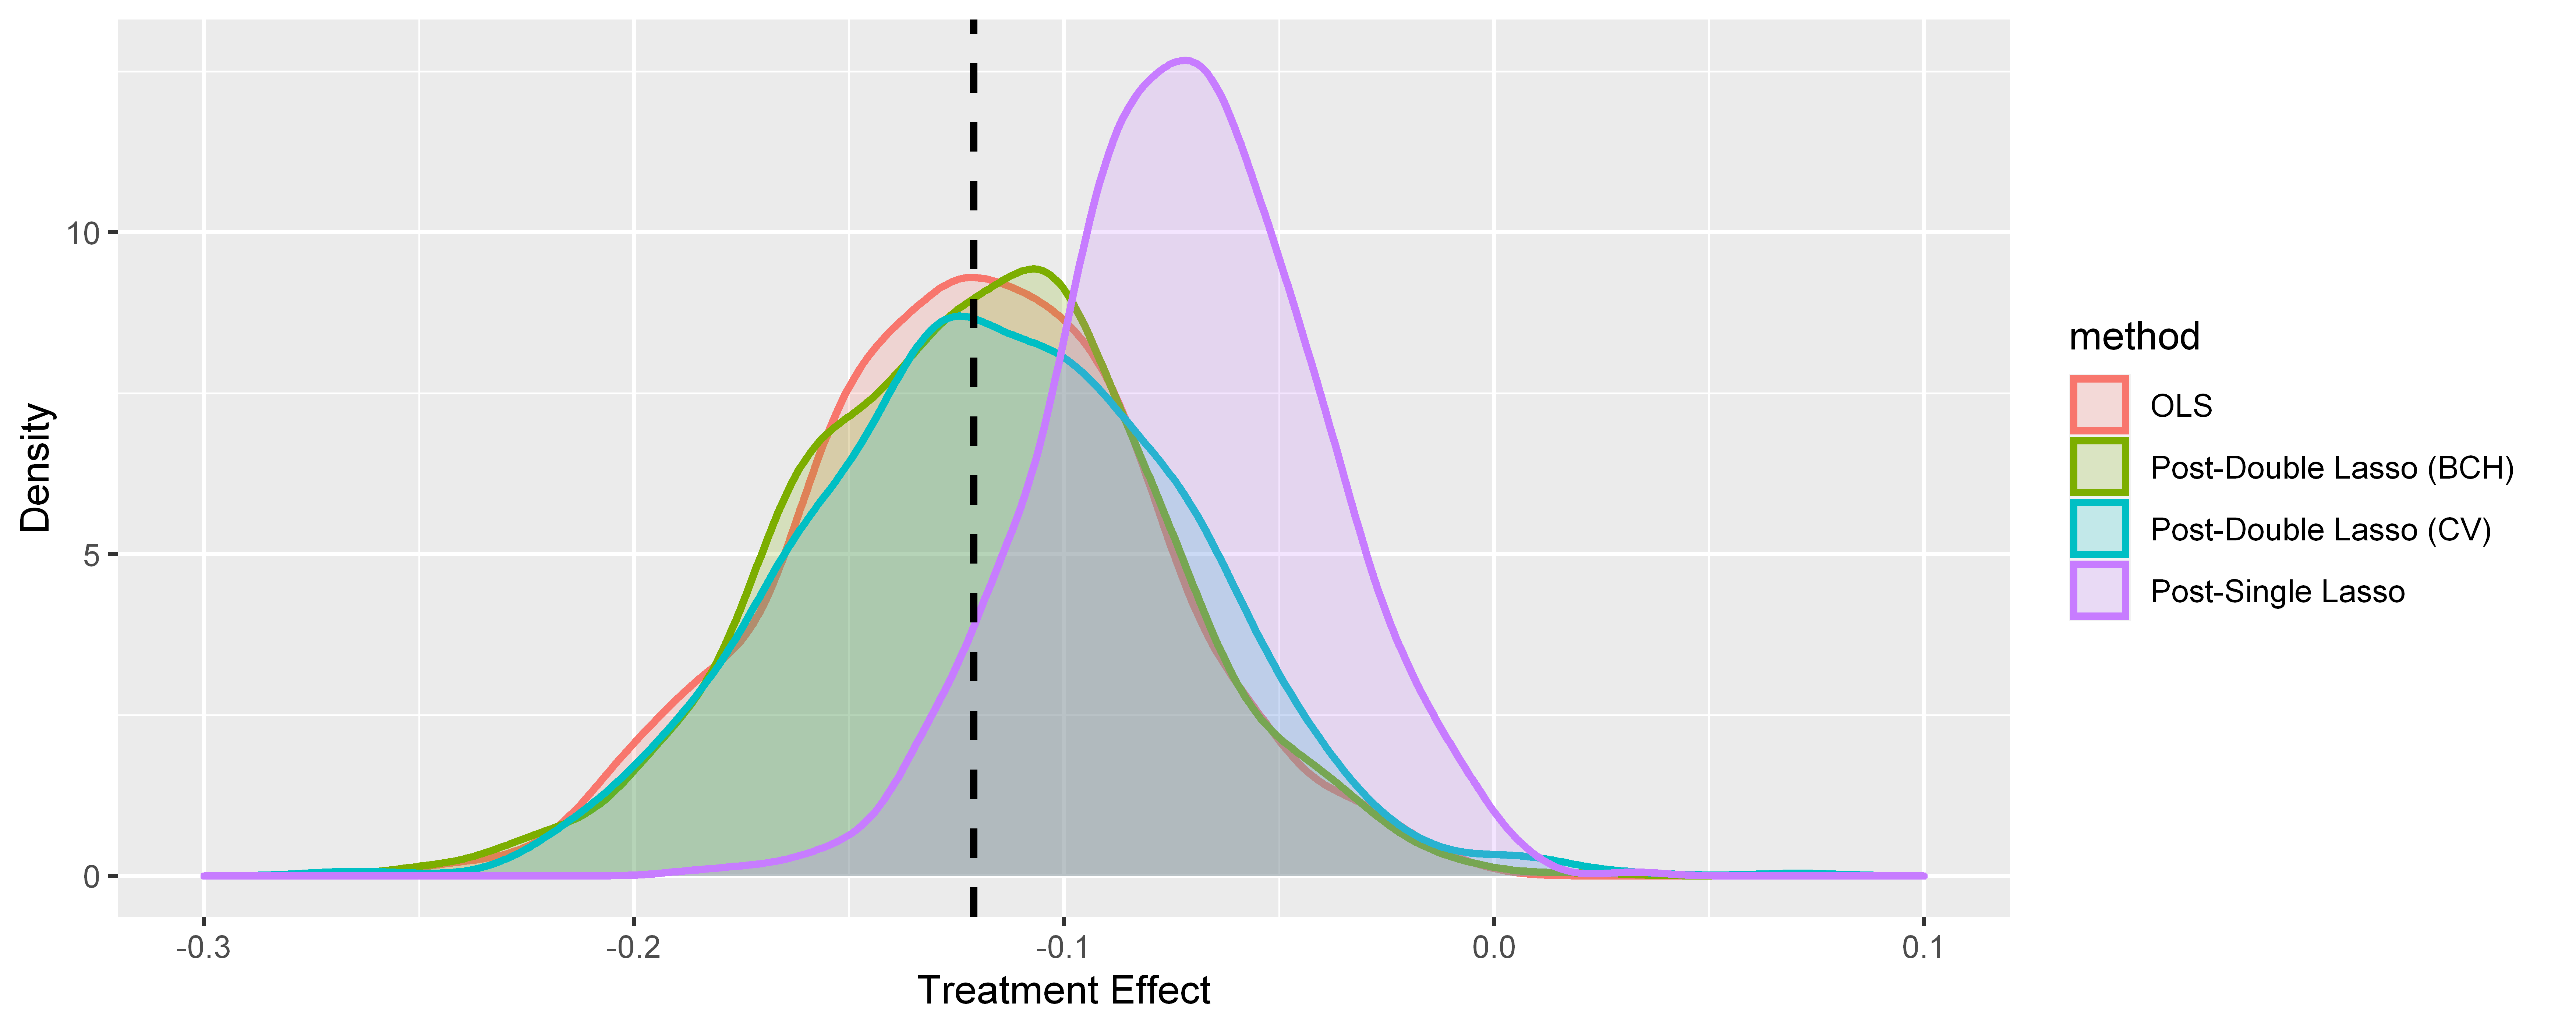

In [16]:
violentcrime <- readRDS(file = "./Minh_Tri_Hoang_Estimates/Minh_Tri_Hoang_violentcrime.Rda")
propertycrime <- readRDS(file = "./Minh_Tri_Hoang_Estimates/Minh_Tri_Hoang_propertycrime.Rda")
murder <- readRDS(file = "./Minh_Tri_Hoang_Estimates/Minh_Tri_Hoang_murder.Rda")

ggplot(violentcrime, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.129, linetype = 'dashed', size = 1)

ggplot(propertycrime, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.091, linetype = 'dashed', size = 1)

ggplot(murder, aes(x = te, color = method, fill = method)) + geom_density(alpha = .2, size = 1) + 
xlab("Treatment Effect") + ylab("Density") + xlim(-.3, .1) +
geom_vline(xintercept = -.121, linetype = 'dashed', size = 1)

Generate a sample from the **dgp** function

In [17]:
set.seed(123)

N <- 576
P <- 284
alpha <- c(-0.129, -0.027, -0.028, 0.069, 0.049, -0.001, 0.008, -0.004, 0.004) 
# coefficients are taken from Donohue III and Levitt (2001) Table IV, column (2)

dgp(N, P, alpha) %>% head()

,Y,D,V1,V2,V3,V4,V5,V6,V7,V8,...,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284
,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.524433366,-0.59401977,-0.56047565,0.67325386,0.5910619,-1.0786789,-0.7761839,-1.0728246,1.13776999,-0.9839385,...,-1.3955299,-0.55115365,-0.4152687,0.7126915,-1.6566863,-0.28784467,0.45618989,0.19055665,1.627175643,-0.4767311
2,0.525143063,-0.06941817,-0.23017749,0.07216675,0.1731049,0.1071888,1.1396777,-0.2298288,1.71439383,-1.6101230,...,0.8675982,0.97921479,0.4090236,-0.3295590,1.7072743,0.42950293,-1.83449452,0.79349600,-0.475064143,-0.9219033
3,-0.008725332,3.31760905,1.55870831,-1.50775732,1.3997834,1.5984875,2.2007603,0.6216372,0.05460957,-0.4301688,...,1.0716767,1.75452015,0.6344073,0.9845721,-1.0805215,-0.89870758,-0.56104762,1.02824644,-0.141334188,-0.3444059
4,-1.737396266,2.08707641,0.07050839,0.02610023,0.1174596,-1.5153241,1.4772053,0.8374455,0.58572200,-1.2242106,...,-0.6651007,0.66396198,-1.3123938,0.4519647,-0.9334973,1.90485444,0.65394918,-0.50702406,0.002993528,-2.1227008
5,0.155068370,-0.06437738,0.12928774,-0.31641587,-0.3315458,0.4336760,-0.4544179,-0.3028880,0.60970219,1.0866420,...,0.3737136,1.24221332,0.0482976,-0.1957414,0.7967677,0.05998649,-0.08140529,0.03556994,-1.200292515,1.4455843
6,0.655127064,-1.77597161,1.71506499,-0.10234651,0.2782949,0.8995448,-1.8228873,-0.1515525,1.19358201,-0.3348056,...,-0.6119065,-0.02802387,0.4826403,0.9940168,-0.5004624,-1.98003518,-0.63078852,-1.15319838,0.632441520,0.4382993
